In [575]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np
import pickle
from utils import *

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [576]:
FN = "../attention_data/attention_data.pkl"
FN2 = "../attention_data/attention_data_multi_imdb.pkl"

In [577]:
# df = pd.read_pickle(FN)
# df2 = pd.read_pickle(FN2)
# df = pd.concat([df, df2])

df = pd.read_pickle(FN2)

In [578]:
QDIR = os.path.join("/Users/pari/LatencyCollector/queries")
JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))
ERG_QNAMES = get_qnames(os.path.join(QDIR, "ergast-small"))
STATS_QNAMES = get_qnames(os.path.join(QDIR, "stats"))
JOBLT_QNAMES = get_qnames(os.path.join(QDIR, "joblight_train"))
STACK_QNAMES = get_qnames(os.path.join(QDIR, "stack-small"))
TPCH_QNAMES = get_qnames(os.path.join(QDIR, "tpch"))
ACC_QNAMES = get_qnames(os.path.join(QDIR, "accidents"))

qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
for qname in ERG_QNAMES:
    qworkloads[qname] = "ErgastF1"
for qname in STATS_QNAMES:
    qworkloads[qname] = "Stats"
for qname in JOBLT_QNAMES:
    qworkloads[qname] = "JOB-LT"
for qname in STACK_QNAMES:
    qworkloads[qname] = "Stack"
for qname in TPCH_QNAMES:
    qworkloads[qname] = "TPCH"
    
df["query_workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)

In [579]:
print(set(df["query_workload"]))

{'CEB'}


# Load log files

In [580]:
import glob
from io import StringIO

LT_FN = "lt_instances.txt"
LDIRS=["new", "concurrent"]
LDIR_BASE = "/Users/pari/prism-testbed/LatencyCollectorResults/"
instance_names = list(set(df["instance"]))
tags = list(set(df["tag"]))

LT_TYPES = '''a1_large_mag_4g=lt-0d15fb8f5bbe9a27d
a1_large_gp3_4g=lt-04840b55d3f795395
r7g_large_gp2_16g=lt-0212ec953ba35b176
t3_large_gp2_8g=lt-05d2d354bc3dd9133
c5a_large_mag_4g=lt-03218e9e27718bbbe
m6a_large_mag_8g=lt-0f6f46002652f9a4c
t3a_medium_gp3_4g=lt-0af65294350b1a8c1
t3a_large_gp3_8g=lt-084bfbae110d52d4e
r6a_large_mag_16g=lt-0e608666ff3adff07
t4g_large_mag_8g=lt-04e0b4826c63bfadb
c7g_large_mag_4g=lt-0af47c6caa3b53b8b
r7g_medium_gp2_16g=lt-01d0081183a7d79f2
t3_xlarge_gp2_16g=lt-0b413bcc22b3ac8fb
'''

lt_types = pd.read_csv(StringIO(LT_TYPES), sep="=", header=None, 
                       names=["lt_type", "lt"])

all_logdfs = {}
for ldir in LDIRS:
    ldir = os.path.join(LDIR_BASE, ldir)
    for tag in tags:
        resultdir = os.path.join(ldir, tag)
        if not os.path.exists(resultdir):
            continue
        ## load all these log files
        logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
    
        instance_dirs = os.listdir(resultdir)
        
        for iname in instance_dirs:
            if os.path.isdir(os.path.join(resultdir, iname)):
                all_logdfs[iname] = {}
            else:
                print(iname)

        ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
               names=["instance", "lt"])
        ltdf = ltdf.merge(lt_types, on="lt")

        for fi, fn in enumerate(logfns):
            instance_name = os.path.basename(os.path.dirname(os.path.dirname(fn)))
            logdfs = all_logdfs[instance_name]

            if ".csv" in fn or "sar_logs00" in fn:
                continue
            try:
                curdf = pd.read_csv(fn, delimiter=";")
                #curdf["instance"] = instance_name
                #curdf = curdf.merge(ltdf, on="instance")
            except Exception as e:
                print("Exception@")
                print(e)
                continue
            
            try:
                ts_reps = curdf.groupby("timestamp")["interval"].count()\
                    .reset_index().sort_values(by="interval",
                     ascending=False)["interval"].values[0]
            except Exception as e:
                print(e)
                continue
            
            if ts_reps > 1:
                curdf = curdf.groupby("timestamp").mean().reset_index()
                curdf = curdf.drop(columns=["interval"])
            else:
                curdf = curdf.drop(columns=["# hostname", "interval"])

            if 'kbmemfree' in curdf.keys():
                logdfs["mem"] = curdf
            elif "dropd/s" in curdf.keys():
                logdfs["network1"] = curdf
            elif "%sio-10" in curdf.keys():
                #system load and pressure-stall statistics
                logdfs["pressure_io"] = curdf
            elif 'kbhugfree' in curdf.keys():
                logdfs["hugepg"] = curdf
            elif '%smem-10' in curdf.keys():
                logdfs["pressure_mem"] = curdf
            elif 'kbswpfree' in curdf.keys():
                logdfs["swap"] = curdf
            elif 'idgm6/s' in curdf.keys():
                logdfs["network2"] = curdf
            elif 'bdscd/s' in curdf.keys():
                logdfs["io1"] = curdf
            elif '%irq' in curdf.keys():
                logdfs["cpu_utilization"] = curdf
            elif 'atmptf/s' in curdf.keys():
                logdfs["network3"] = curdf
            elif 'idgm/s' in curdf.keys():
                logdfs["network4"] = curdf
            elif 'areq-sz' in curdf.keys():
                logdfs["device_io"] = curdf
            elif 'call/s' in curdf.keys():
                logdfs["network_nfs"] = curdf
            elif 'rxdrop/s' in curdf.keys():
                logdfs["network5"] = curdf
            elif 'rxcmp/s' in curdf.keys():
                logdfs["network6"] = curdf
            elif 'tcp6sck' in curdf.keys():
                logdfs["network7"] = curdf
            elif 'iseg/s' in curdf.keys():
                logdfs["network8"] = curdf
            elif 'pswpin/s' in curdf.keys():
                logdfs["swap"] = curdf
            elif 'intr/s' in curdf.keys():
                logdfs["interrupts"] = curdf
            elif '%scpu-10' in curdf.keys():
                logdfs["pressure_cpu"] = curdf
            elif 'MHz' in curdf.keys():
                logdfs["power-cpu"] = curdf
            elif 'degC' in curdf.keys():
                logdfs["power-temp"] = curdf
            elif '%ufsused' in curdf.keys():
                logdfs["filesystem"] = curdf
            elif 'cswch/s' in curdf.keys():
                logdfs["context_switch"] = curdf
            elif 'pgpgin/s' in curdf.keys():
                logdfs["paging"] = curdf
            elif 'fwddgm/s' in curdf.keys():
                logdfs["network9"] = curdf
            elif 'ihdrer6/s' in curdf.keys():
                logdfs["network10"] = curdf
            elif 'imsg/s' in curdf.keys():
                logdfs["network11"] = curdf
            elif 'ierr6/s' in curdf.keys():
                logdfs["network12"] = curdf
            elif 'scall/s' in curdf.keys():
                logdfs["network13"] = curdf
            elif 'runq-sz' in curdf.keys():
                logdfs["pressure_load"] = curdf
            elif 'dentunusd' in curdf.keys():
                logdfs["inode"] = curdf
            elif 'igmbq6/s' in curdf.keys():
                logdfs["network14"] = curdf
            elif 'tcpsck' in curdf.keys():
                logdfs["network15"] = curdf
            elif 'otmex/s' in curdf.keys():
                logdfs["network16"] = curdf
            elif 'ihdrerr/s' in curdf.keys():
                logdfs["network17"] = curdf
            elif 'irec6/s' in curdf.keys():
                logdfs["network18"] = curdf
            else:
                assert False
        

lt_instances.txt
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
lt_instances.txt
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
Exception@
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


In [581]:
print("Number of log files: ", len(logdfs))

todel = []
for instance,logdfs in all_logdfs.items():
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]
    if len(tmp) == 0:
        todel.append(instance)
        
for td in todel:
    del all_logdfs[td]

for instance,logdfs in all_logdfs.items():
    print(instance, len(logdfs))
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]

    min_qtime = min(tmp["start_time"].values)
    max_qtime = max(tmp["start_time"].values)

    for k in keys:
        if "network" in k:
            del logdfs[k]
            continue
        if "hugepg" in k:
            del logdfs[k]
            continue

        if len(logdfs[k]) == 0:
            continue

        mincur = min(logdfs[k]["timestamp"])
        logdfs[k]["relative_time"] = logdfs[k].apply(lambda x: x["timestamp"]-min_qtime , axis=1)
        logdfs[k] = logdfs[k][logdfs[k]["relative_time"] >= -10.0]
        
print("Number of log files w/o networking: ", len(logdfs))

Number of log files:  36
i-0ba5474ed648606a8 35
i-0977bc21ad2857f80 36
i-05f53e2df5d9eac9e 36
i-0fa2c87f5fce5a114 35
i-0119bed4d0779429d 35
i-0edbfc5f1f73ff227 36
i-0b3b77148492b56a9 36
i-0ec72cb5e1379cf32 35
i-0d1db8a5fd3e5bc31 36
i-0cf9853ca42d7a9db 36
i-00a721c3b7f3c4192 35
i-04fa18ddf39490753 35
i-0ece8b22646069244 36
i-0c67fcdbf0b538b36 36
i-00f9bdd4074f63925 36
i-0b96ed646f7e538da 36
i-07258494b6d725cca 35
i-0a9d671f5b19f75e2 35
i-02a2448abde1af08d 36
Number of log files w/o networking:  16


In [582]:
key_names = ['%Iused', '%commit', '%fio', '%fio-10', '%fio-300', '%fio-60', '%fmem',
       '%fmem-10', '%fmem-300', '%fmem-60', '%fsused', '%gnice', '%guest',
       '%idle', '%iowait', '%irq', '%memused', '%nice', '%scpu', '%scpu-10',
       '%scpu-300', '%scpu-60', '%sio', '%sio-10', '%sio-300', '%sio-60',
       '%smem', '%smem-10', '%smem-300', '%smem-60', '%soft', '%steal', '%sys',
       '%ufsused', '%usr', '%util', '%vmeff', 'Ifree', 'Iused', 'MBfsfree',
       'MBfsused', 'aqu-sz', 'areq-sz', 'await', 'bdscd/s', 'blocked',
       'bread/s', 'bwrtn/s', 'cswch/s', 'dentunusd', 'dkB/s', 'dtps',
       'fault/s', 'file-nr', 'inode-nr', 'intr/s', 'kbactive', 'kbanonpg',
       'kbavail', 'kbbuffers', 'kbcached', 'kbcommit', 'kbdirty', 'kbinact',
       'kbkstack', 'kbmemfree', 'kbmemused', 'kbpgtbl', 'kbslab', 'kbvmused',
       'ldavg-1', 'ldavg-15', 'ldavg-5', 'majflt/s', 'pgfree/s', 'pgpgin/s',
       'pgpgout/s', 'pgscand/s', 'pgscank/s', 'pgsteal/s', 'plist-sz',
       'proc/s', 'pswpin/s', 'pswpout/s', 'pty-nr', 'rkB/s', 'rtps', 'runq-sz',
       'tps_x', 'tps_y', 'wkB/s', 'wtps']
key_names.sort()

In [583]:
logdf = df[["lt_type", '%Iused', '%commit', '%fio', '%fio-10', '%fio-300', '%fio-60', '%fmem',
       '%fmem-10', '%fmem-300', '%fmem-60', '%fsused', '%gnice', '%guest',
       '%idle', '%iowait', '%irq', '%memused', '%nice', '%scpu', '%scpu-10',
       '%scpu-300', '%scpu-60', '%sio', '%sio-10', '%sio-300', '%sio-60',
       '%smem', '%smem-10', '%smem-300', '%smem-60', '%soft', '%steal', '%sys',
       '%ufsused', '%usr', '%util', '%vmeff', 'Ifree', 'Iused', 'MBfsfree',
       'MBfsused', 'aqu-sz', 'areq-sz', 'await', 'bdscd/s', 'blocked',
       'bread/s', 'bwrtn/s', 'cswch/s', 'dentunusd', 'dkB/s', 'dtps',
       'fault/s', 'file-nr', 'inode-nr', 'intr/s', 'kbactive', 'kbanonpg',
       'kbavail', 'kbbuffers', 'kbcached', 'kbcommit', 'kbdirty', 'kbinact',
       'kbkstack', 'kbmemfree', 'kbmemused', 'kbpgtbl', 'kbslab', 'kbvmused',
       'ldavg-1', 'ldavg-15', 'ldavg-5', 'majflt/s', 'pgfree/s', 'pgpgin/s',
       'pgpgout/s', 'pgscand/s', 'pgscank/s', 'pgsteal/s', 'plist-sz',
       'proc/s', 'pswpin/s', 'pswpout/s', 'pty-nr', 'rkB/s', 'rtps', 'runq-sz',
       'tps_x', 'tps_y', 'wkB/s', 'wtps']]

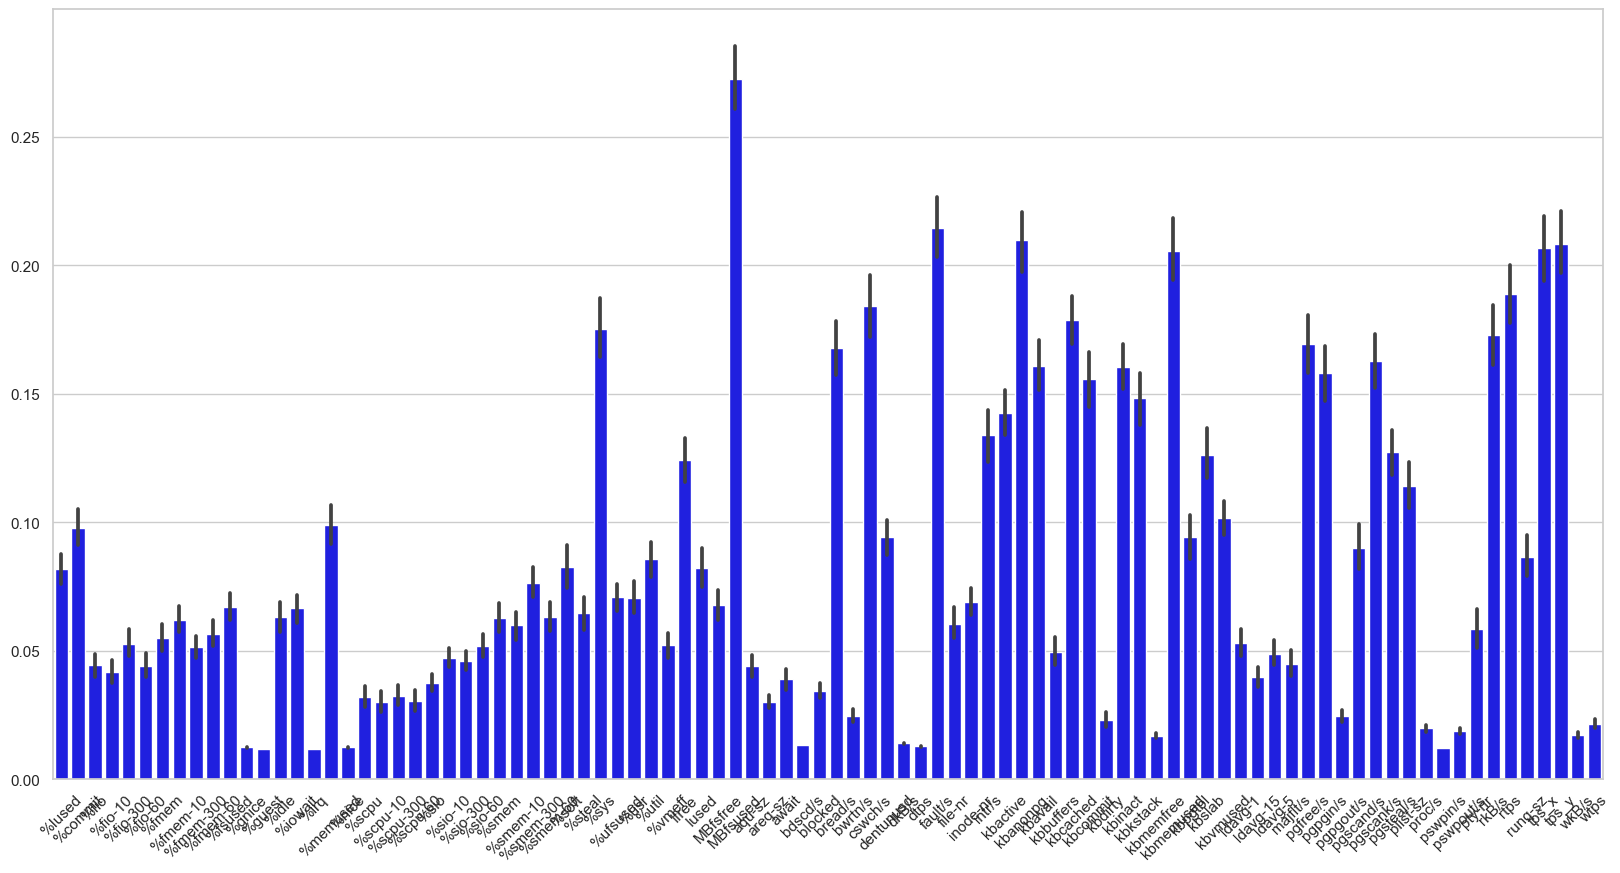

In [584]:
# Plotting
sns.set(style="whitegrid")  # Sets the style of the plots; you can change it
plt.figure(figsize=(20, 10))  # Adjusts the size of the figure

# Create a boxplot for each numeric column
sns.barplot(data=logdf[key_names], color="blue")

# Rotate x labels if there are many columns
plt.xticks(rotation=45)

# Show the plot
plt.show()

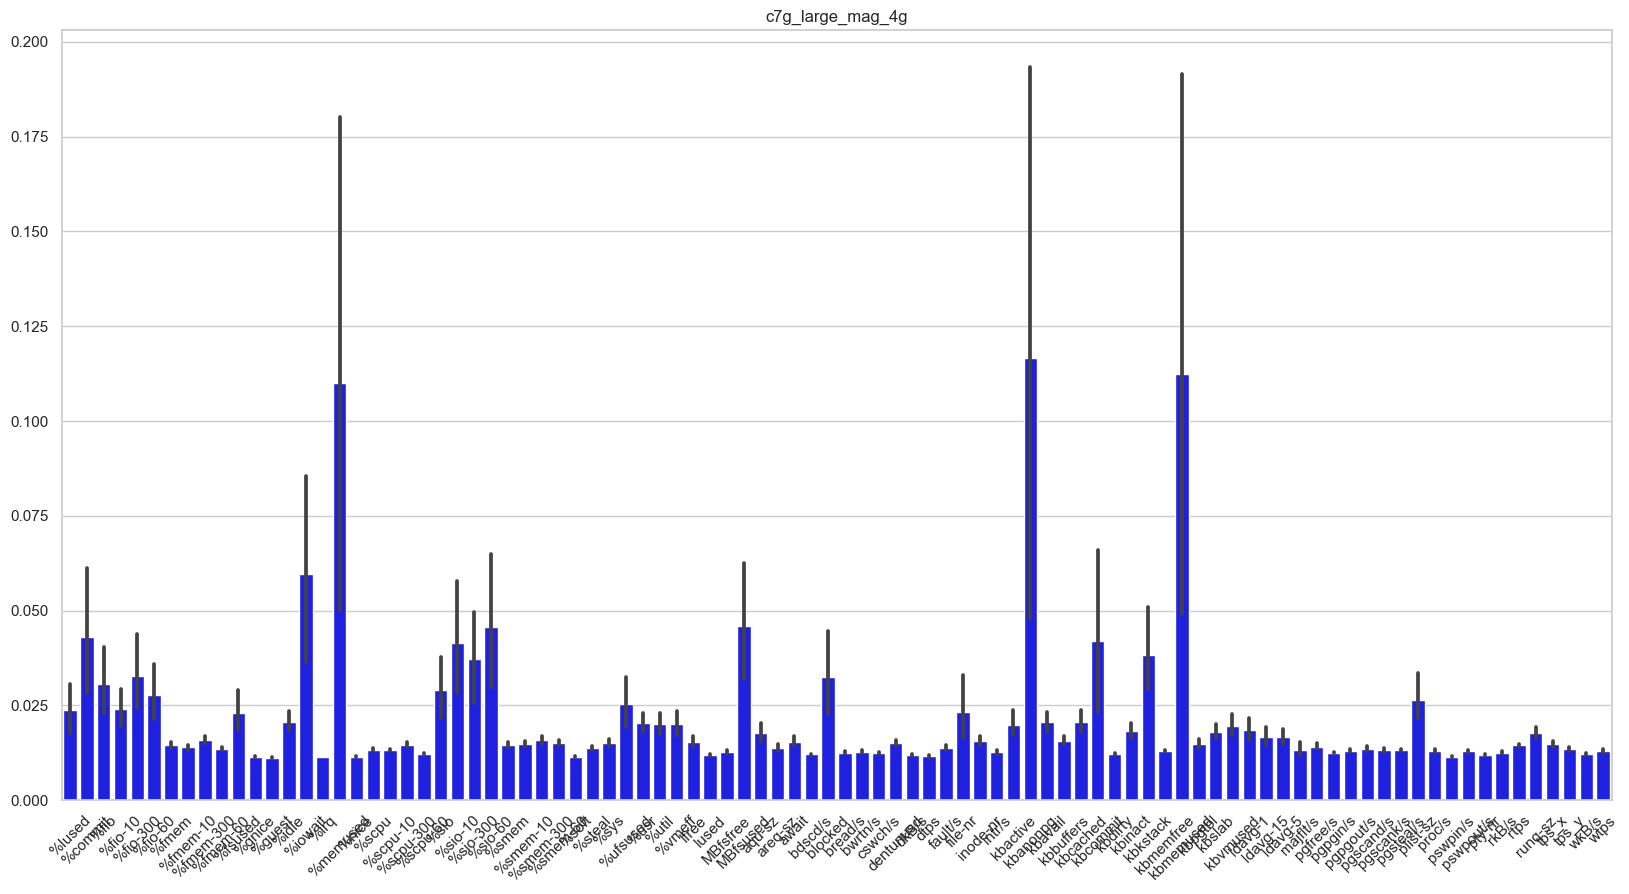

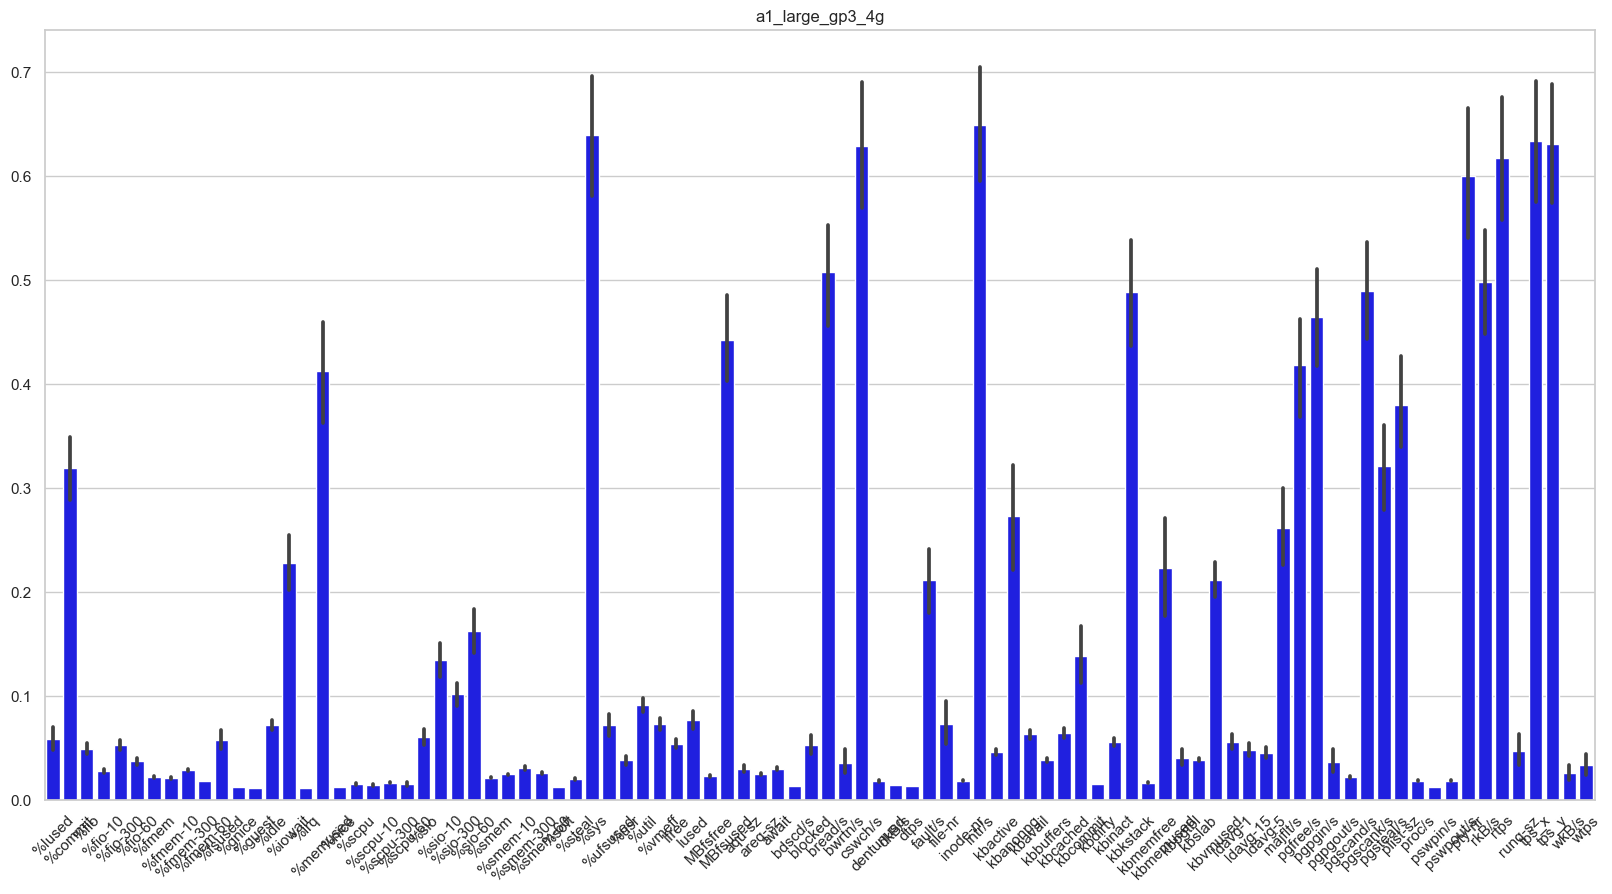

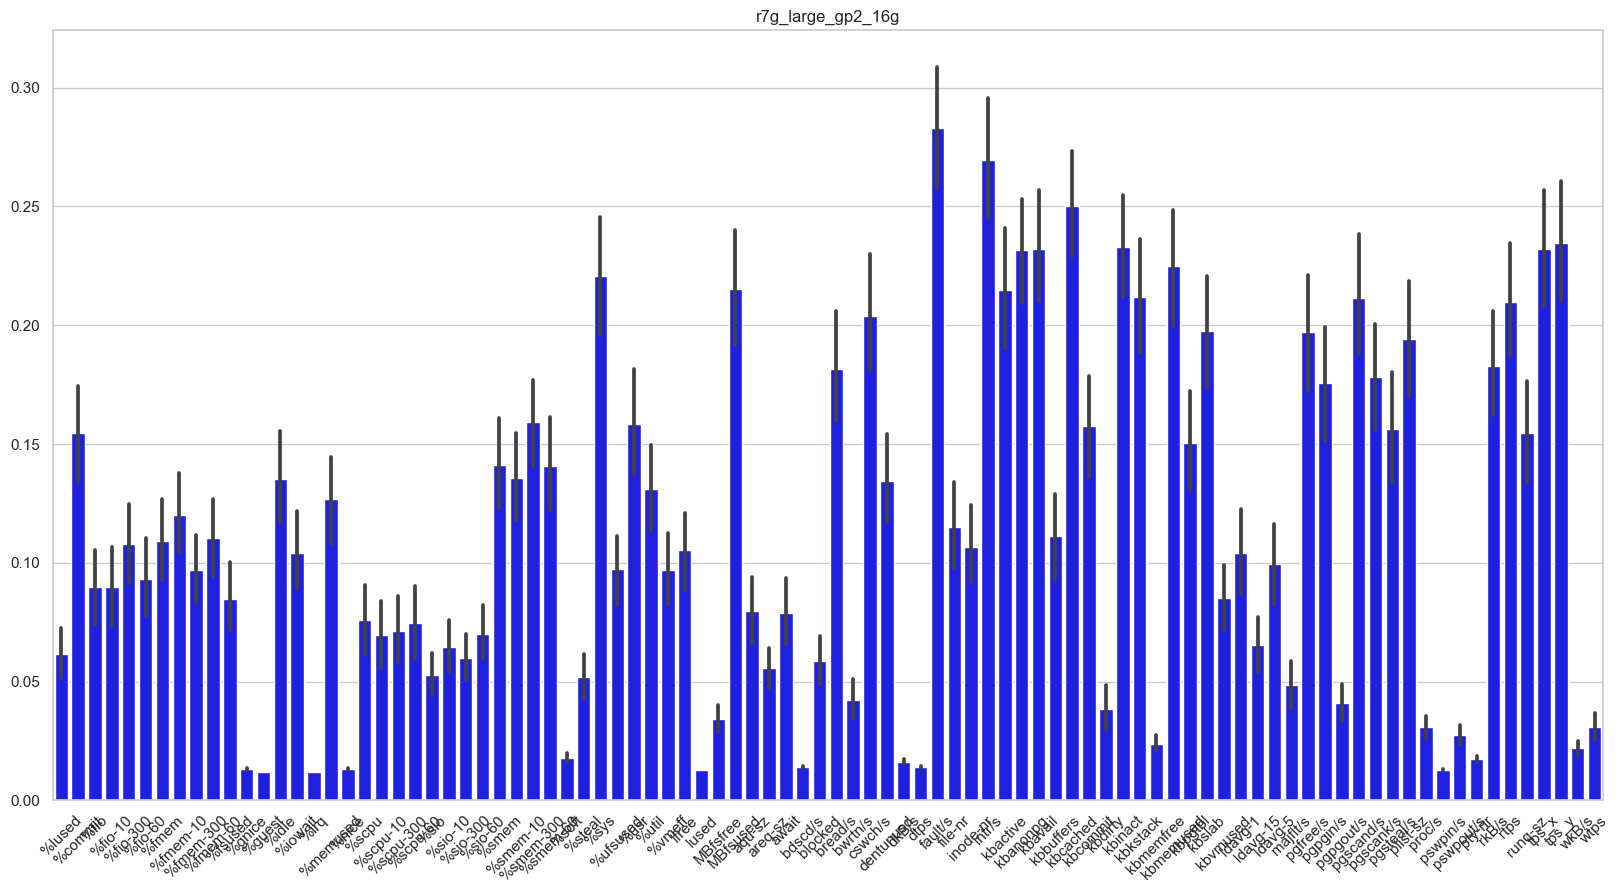

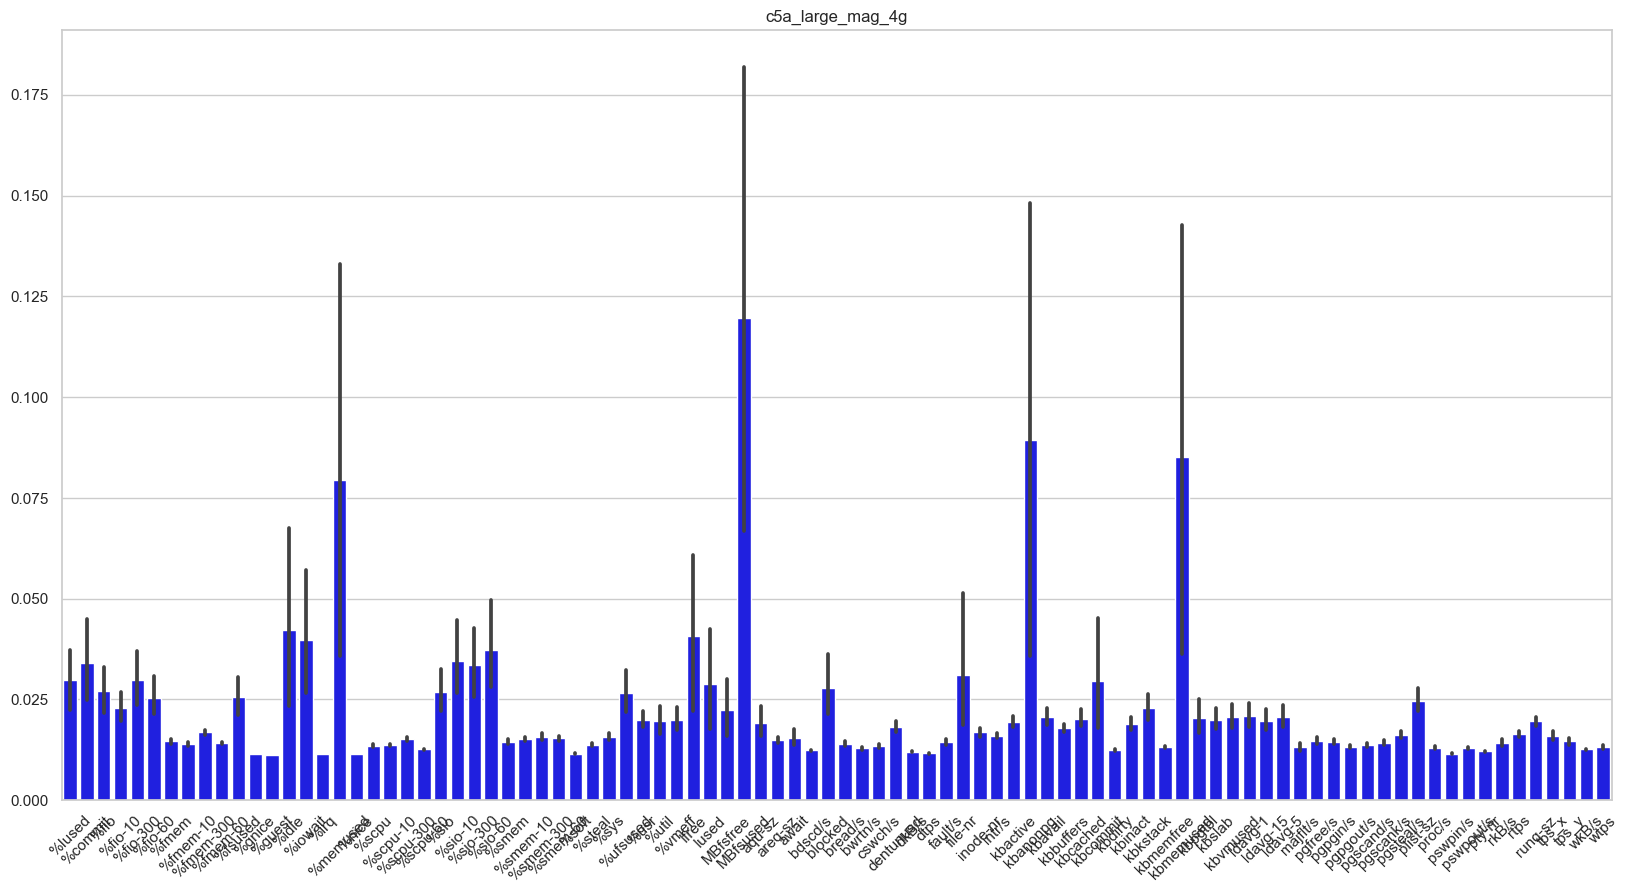

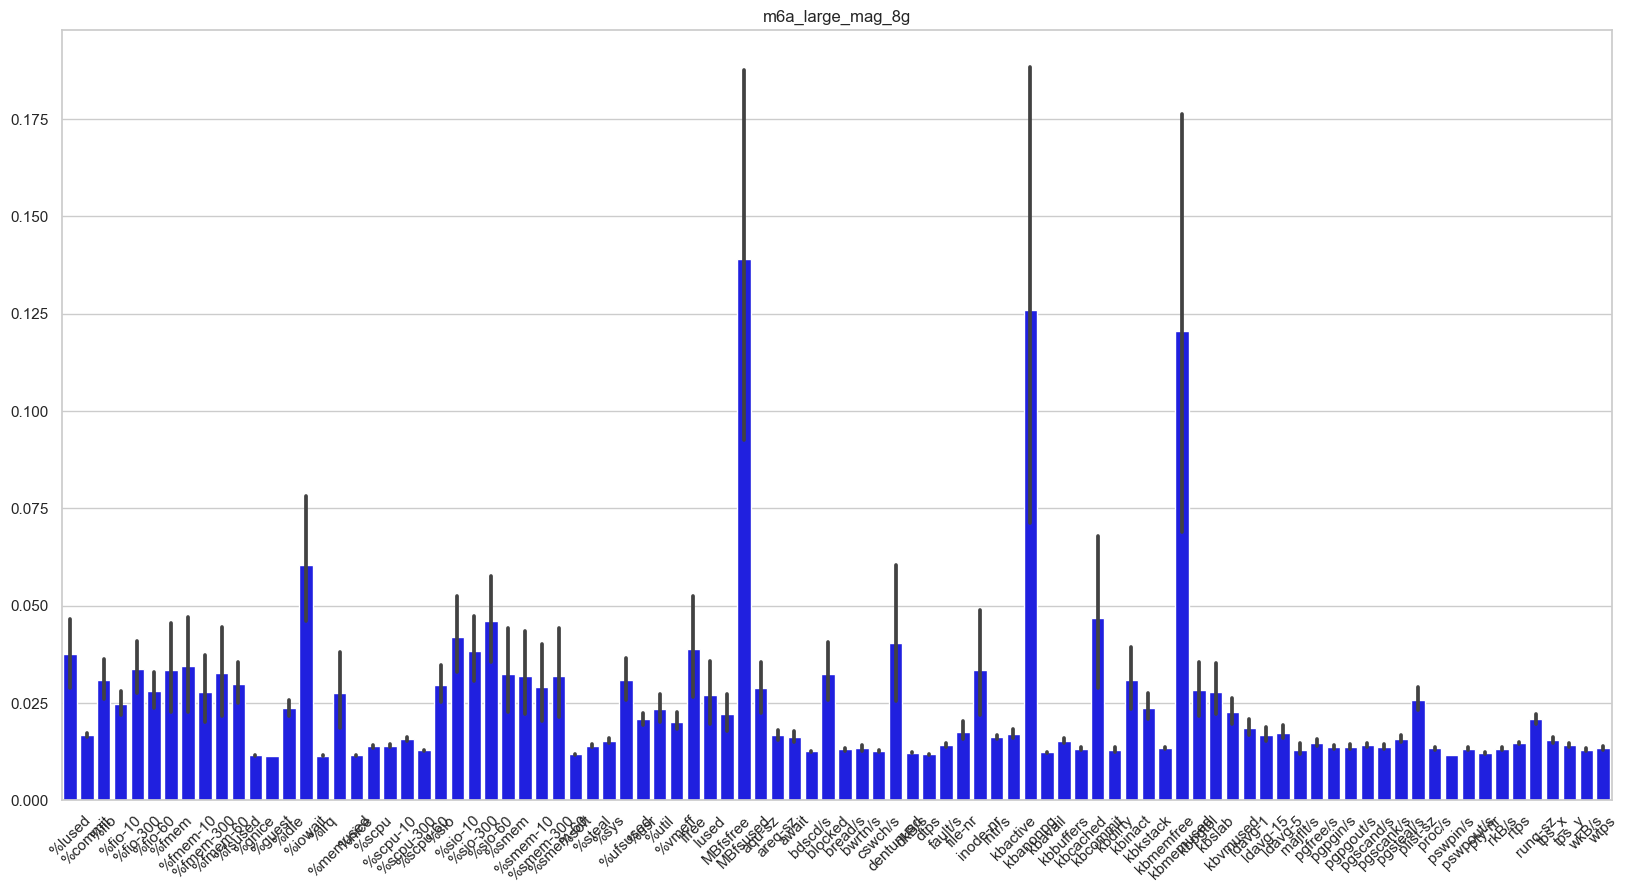

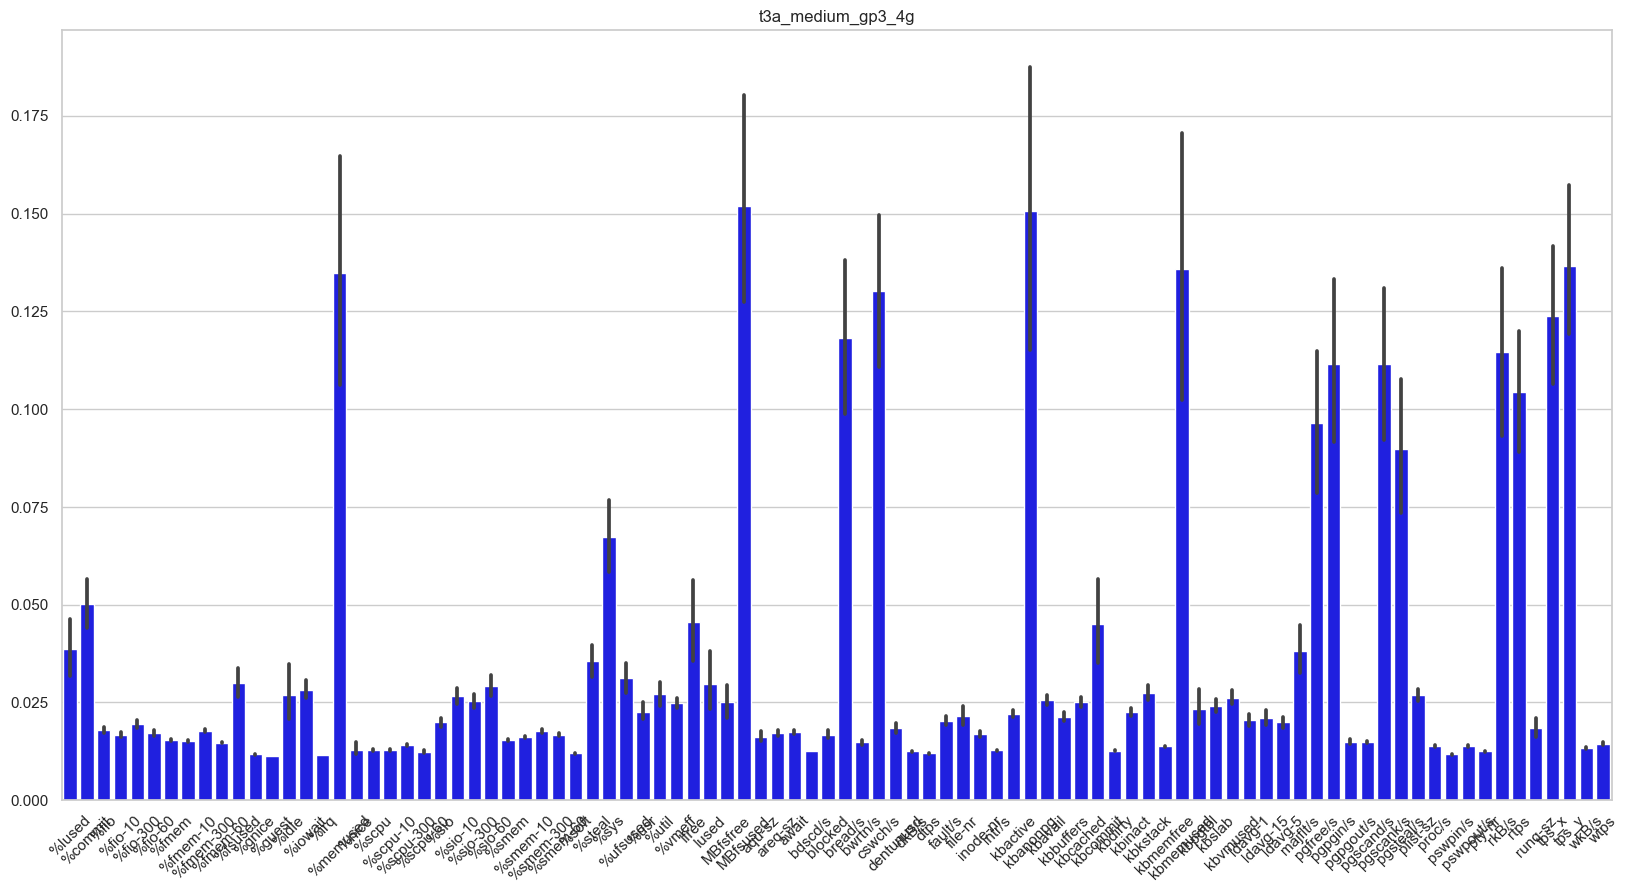

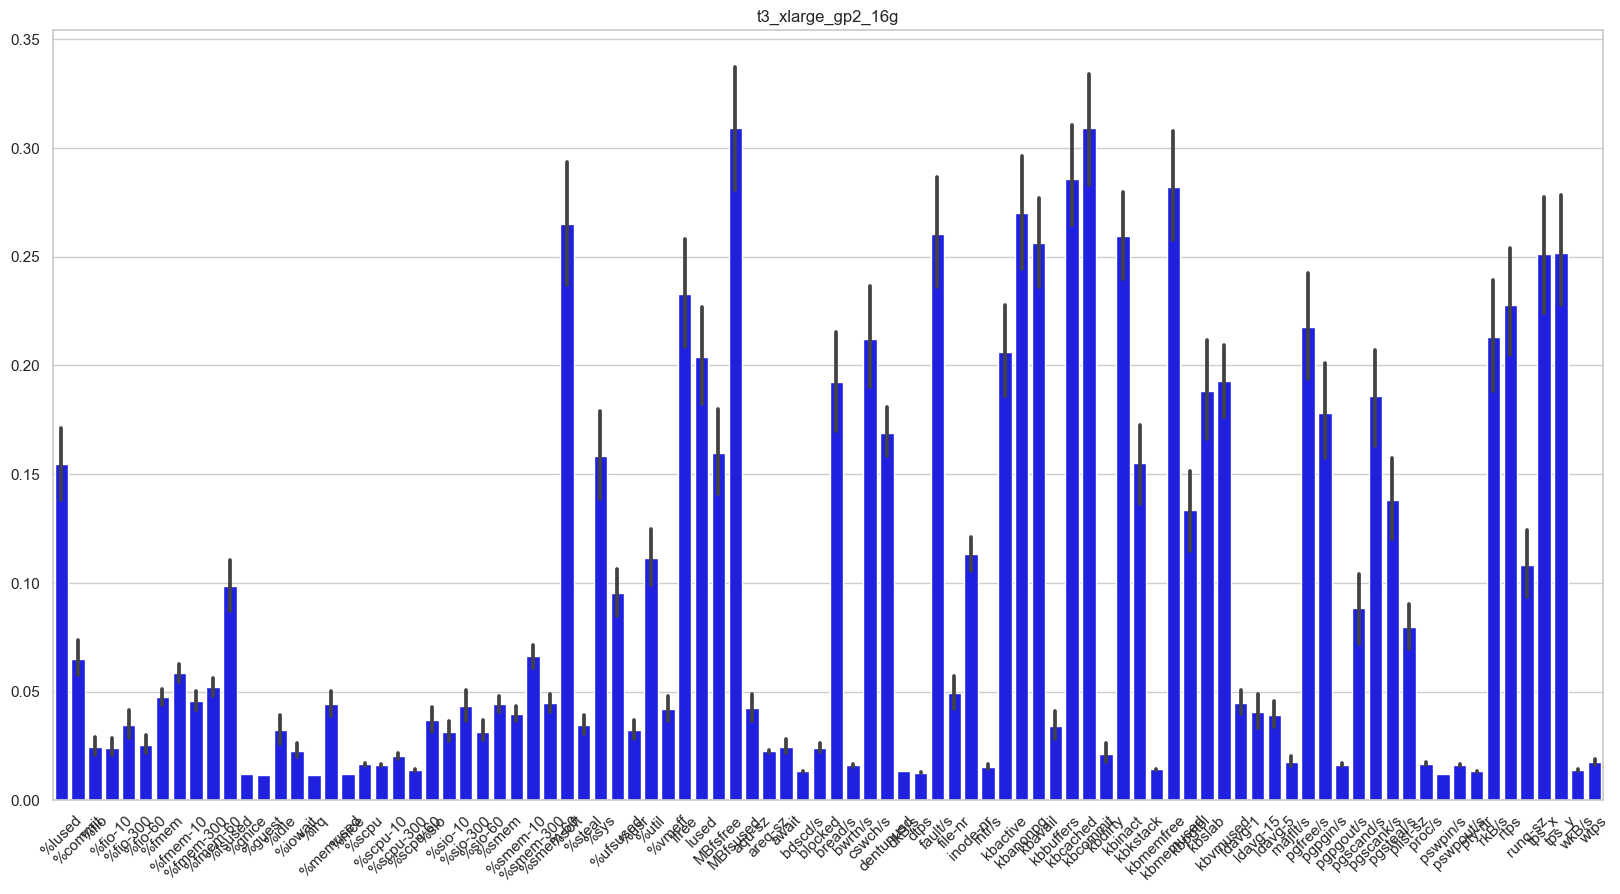

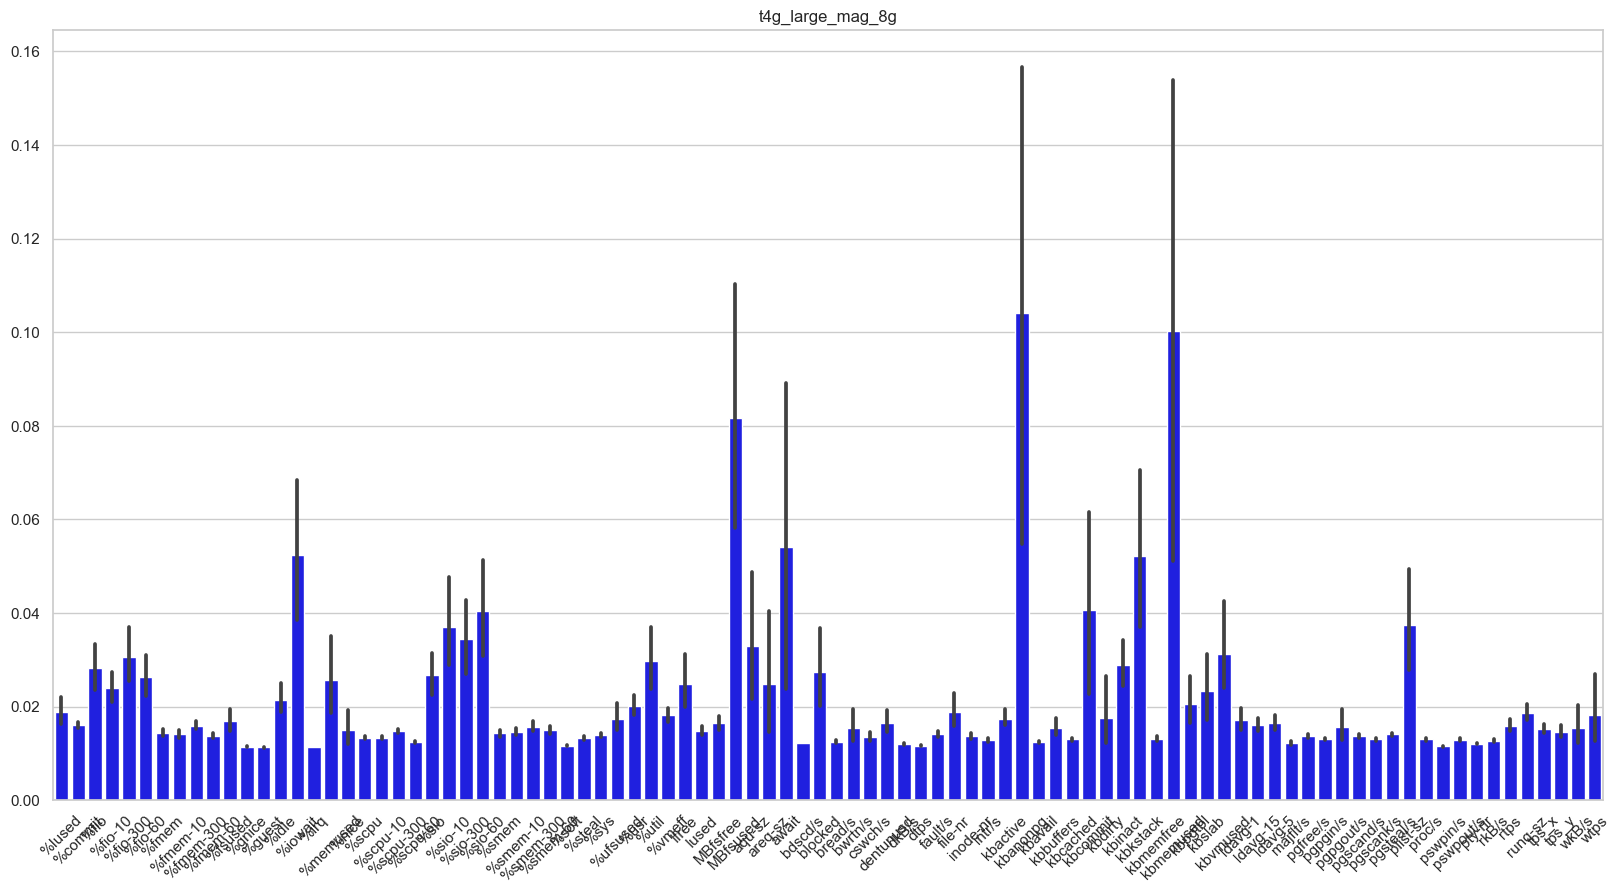

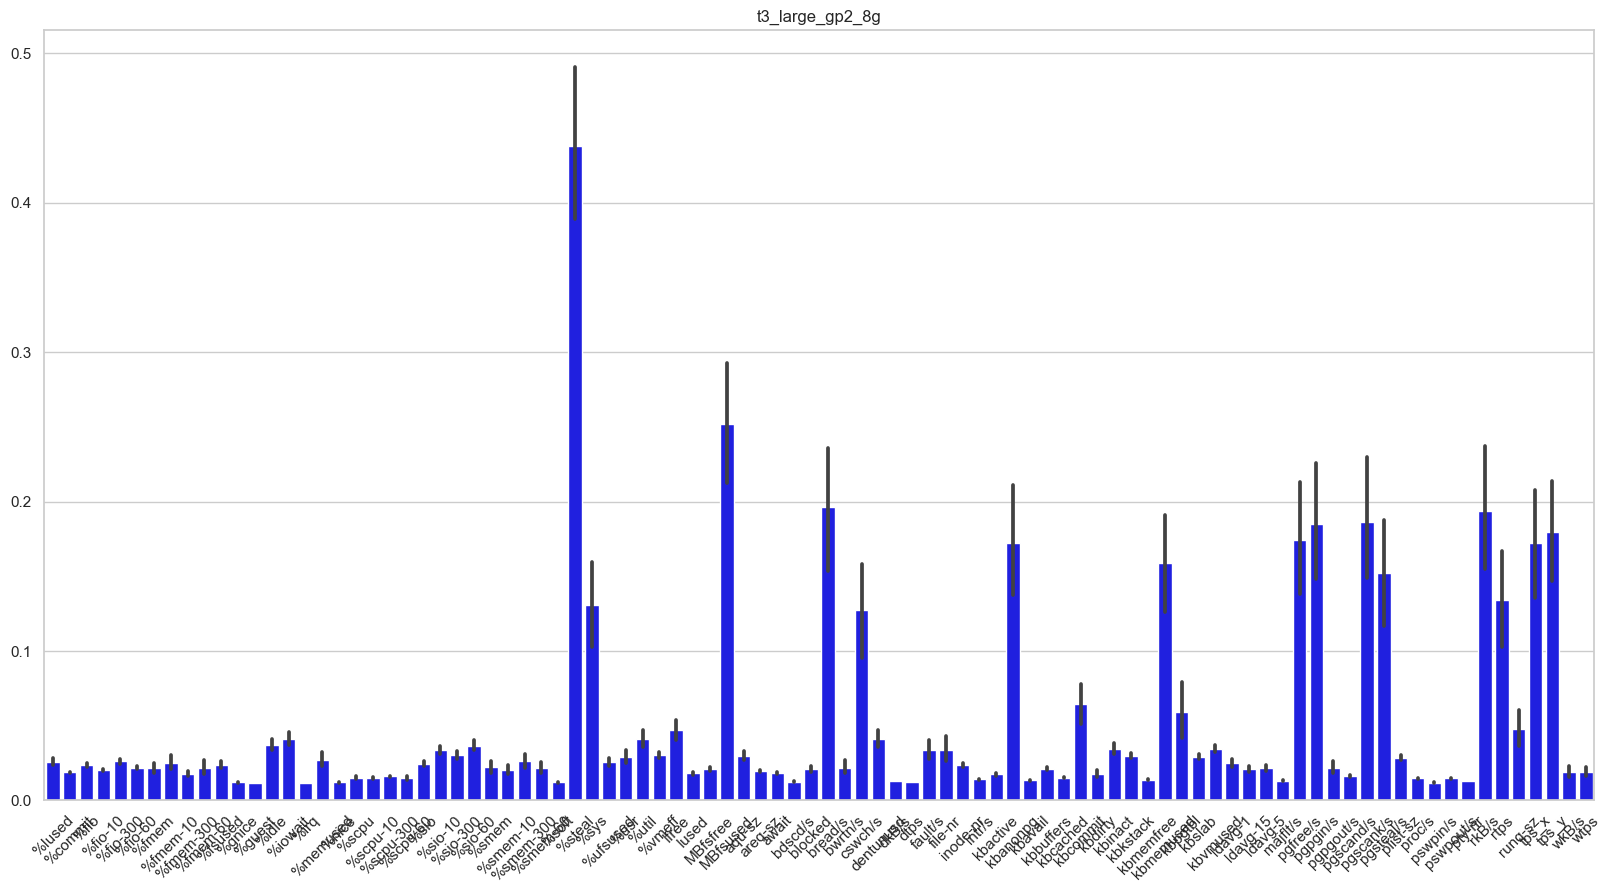

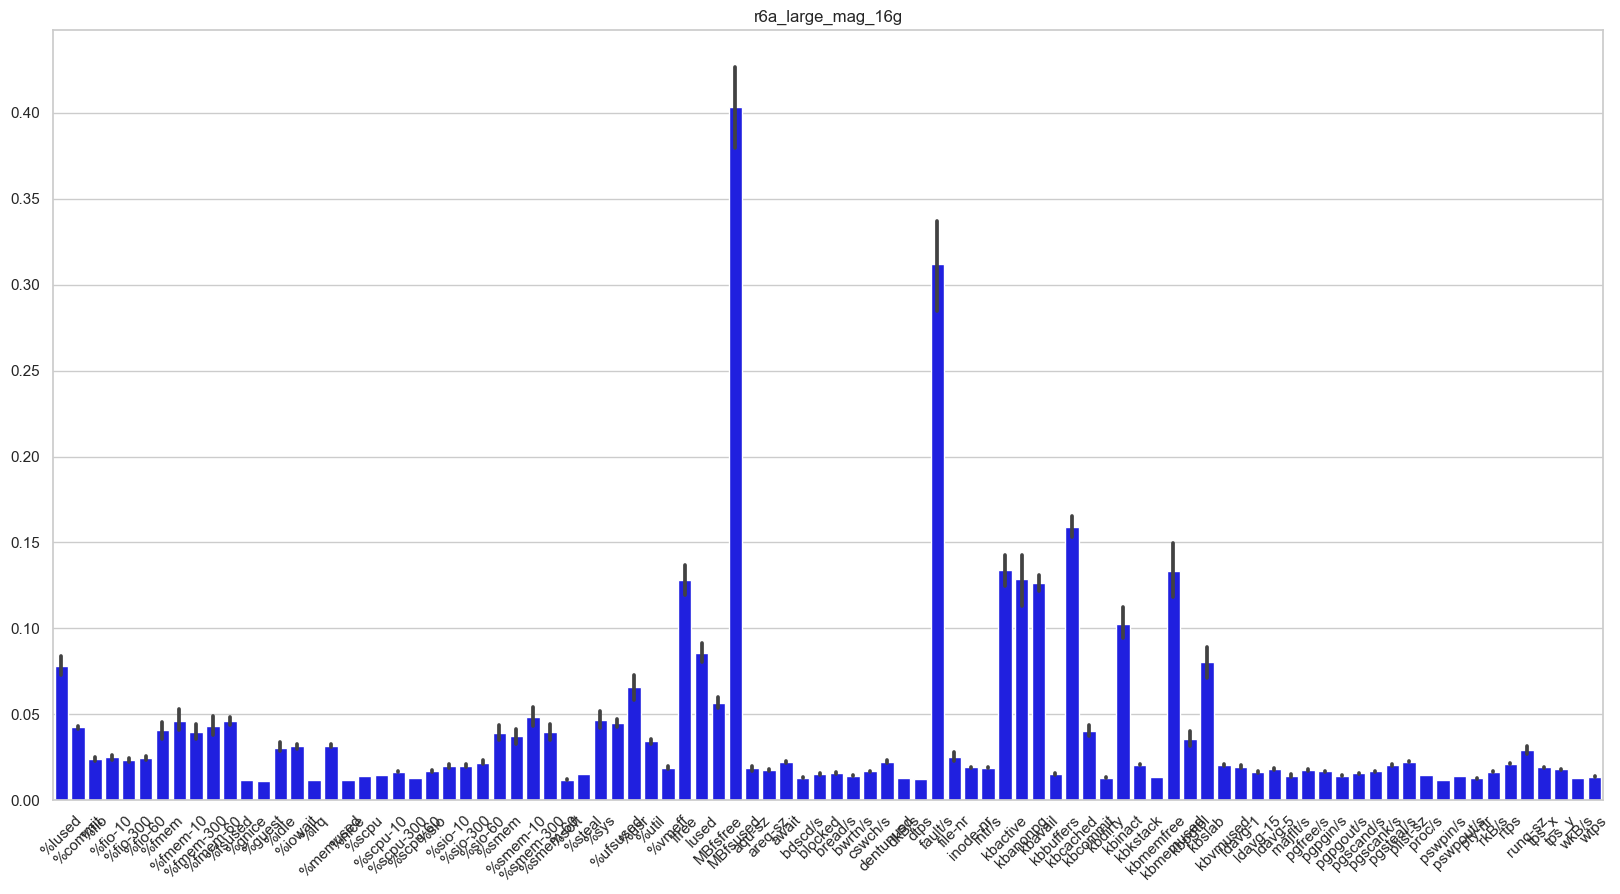

In [585]:
lttypes = set(logdf["lt_type"])

for lt in lttypes:
    tmp = logdf[logdf["lt_type"] == lt]
    # Plotting
    sns.set(style="whitegrid")  # Sets the style of the plots; you can change it
    plt.figure(figsize=(20, 10))  # Adjusts the size of the figure

    # Create a boxplot for each numeric column
    sns.barplot(data=tmp[key_names], color="blue")
    
    plt.title(lt)
    # Rotate x labels if there are many columns
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

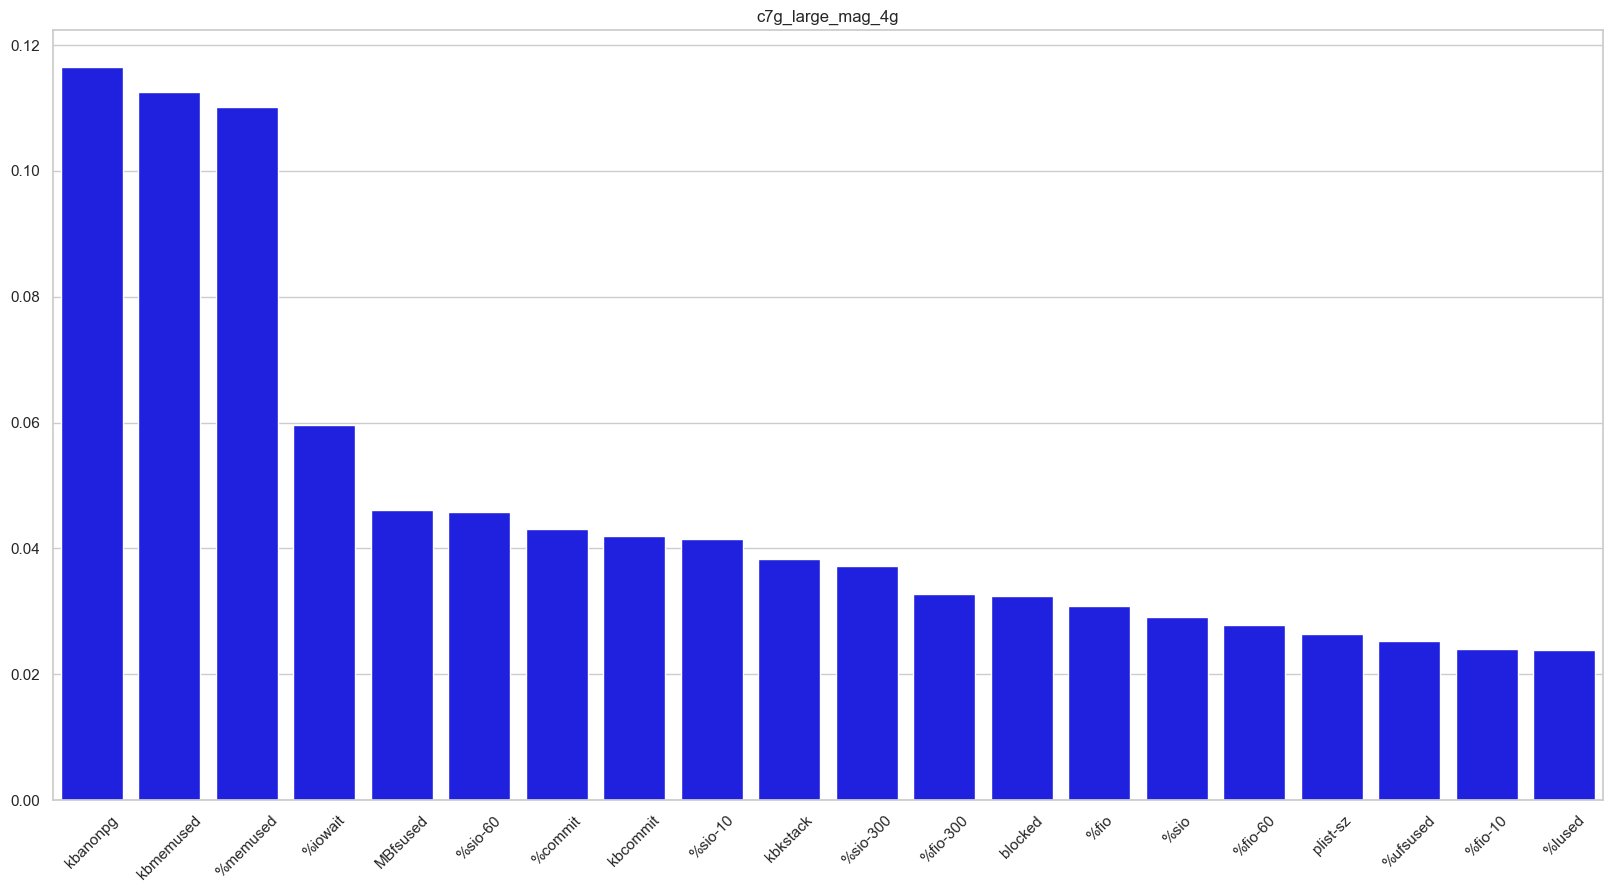

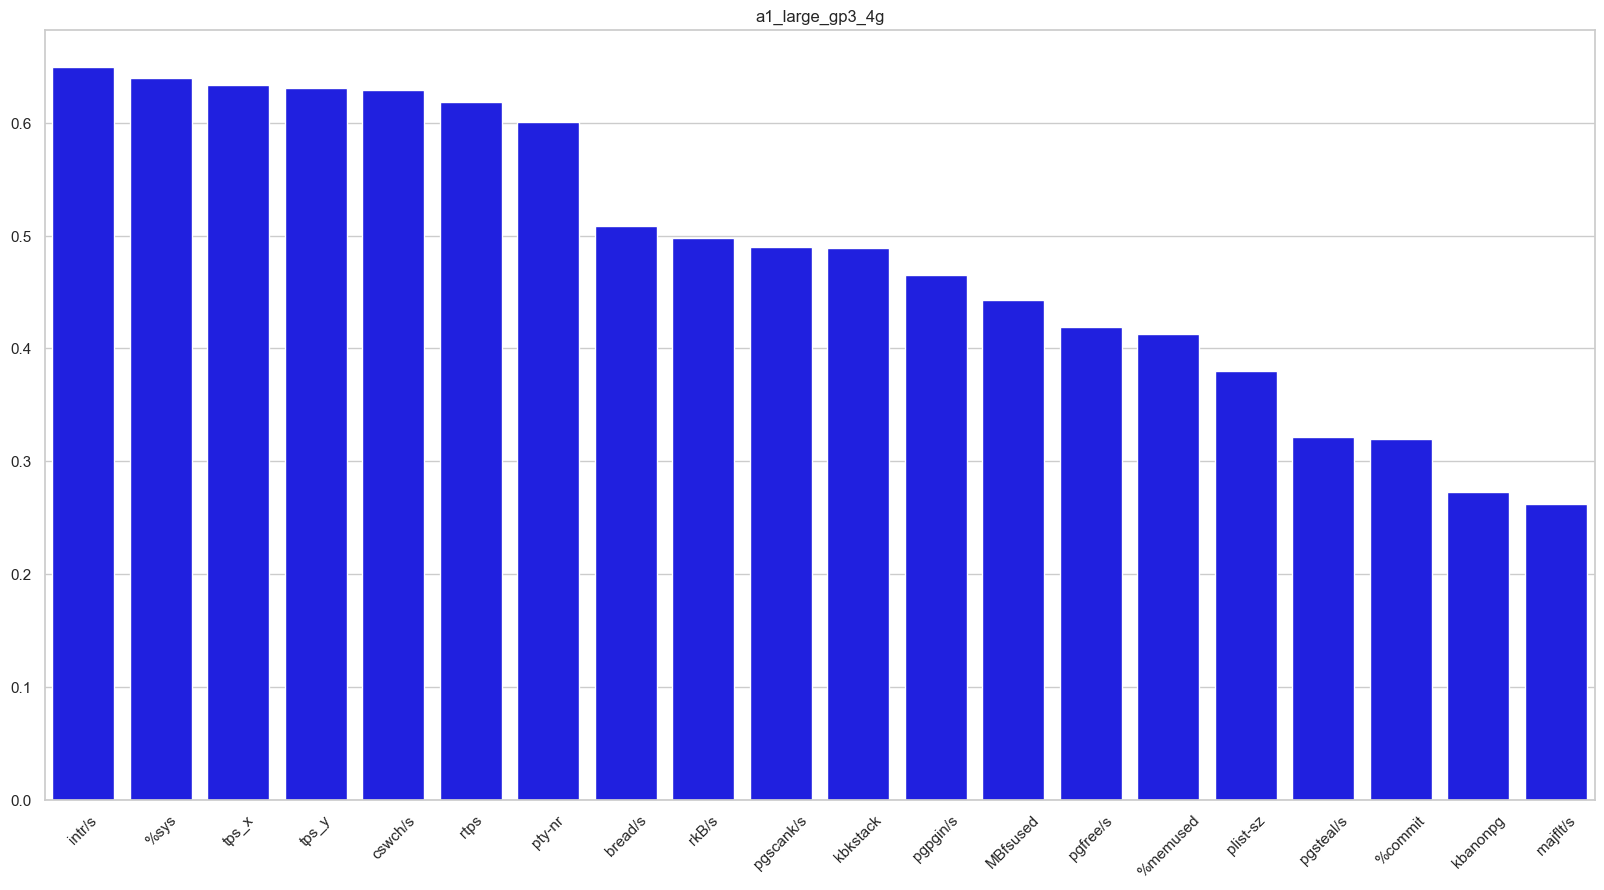

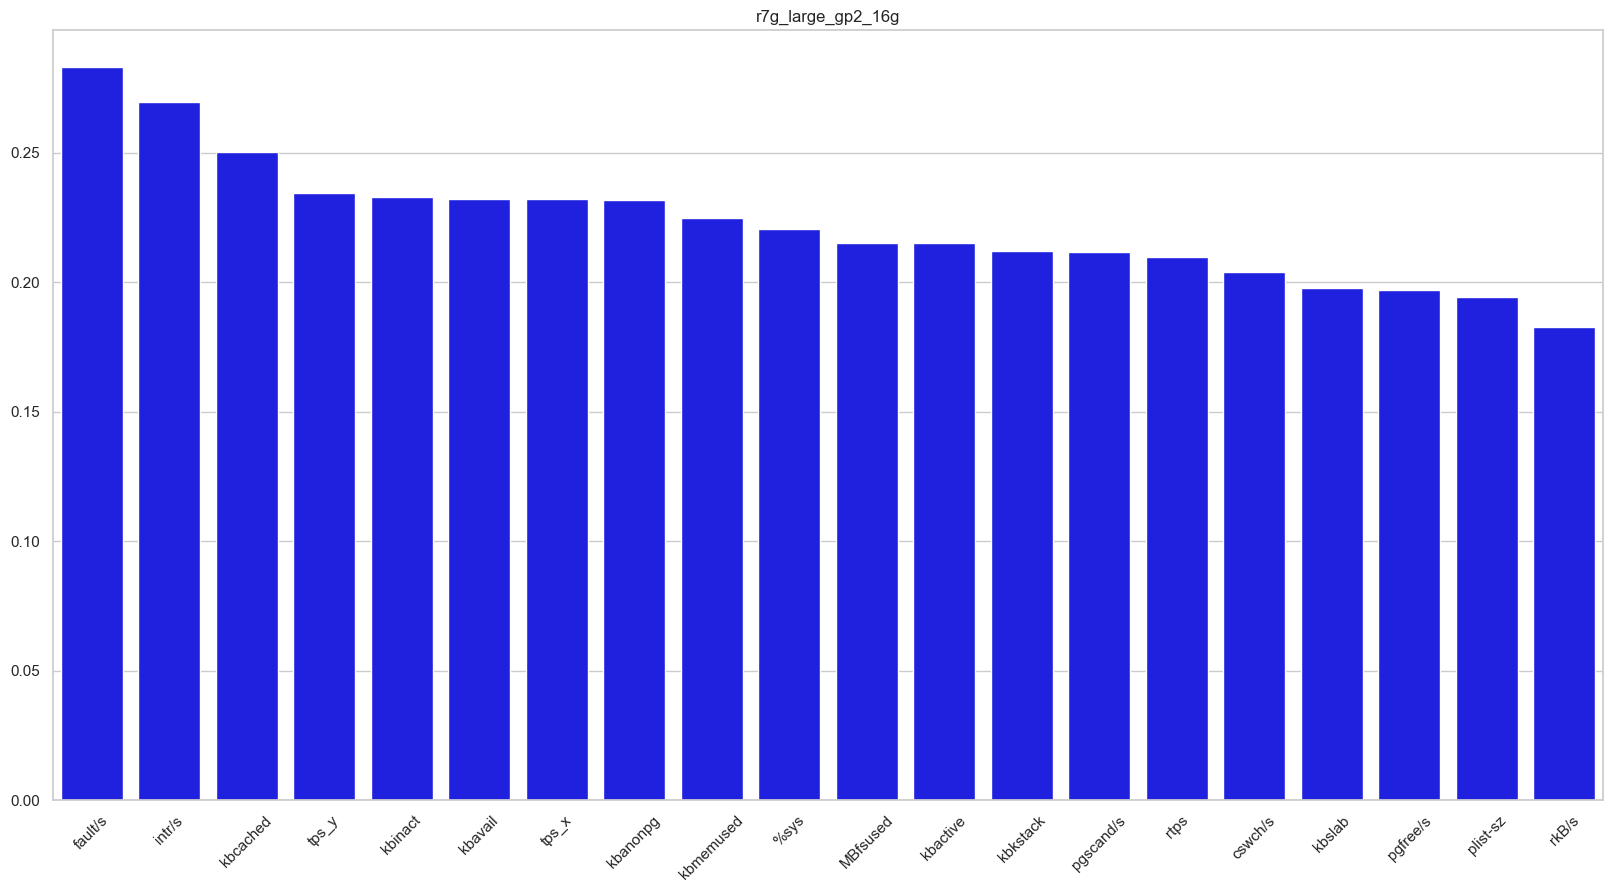

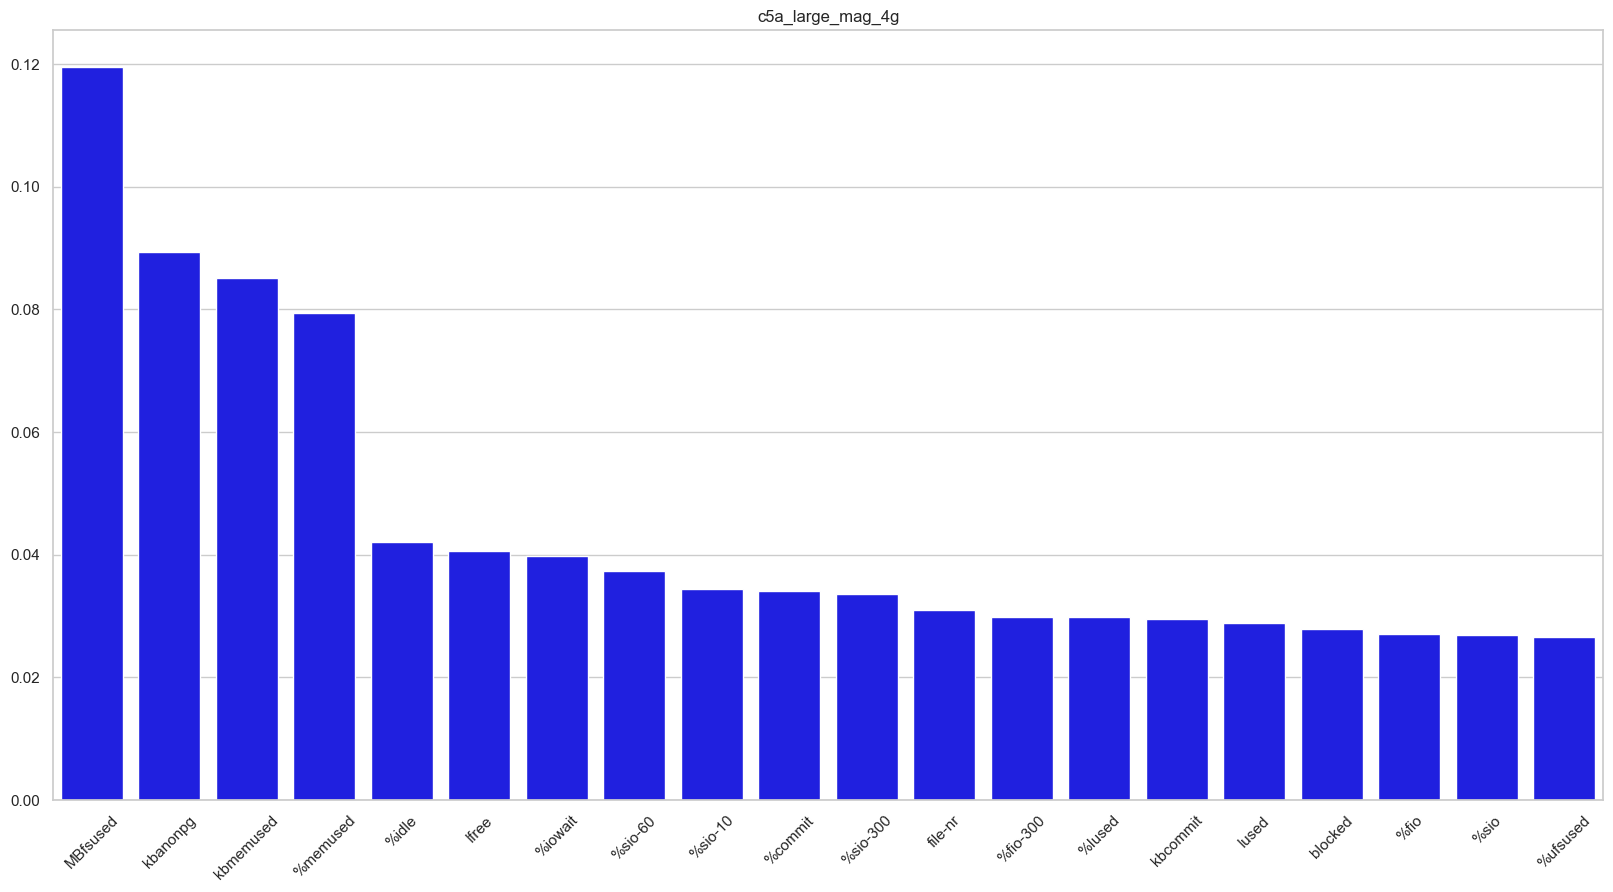

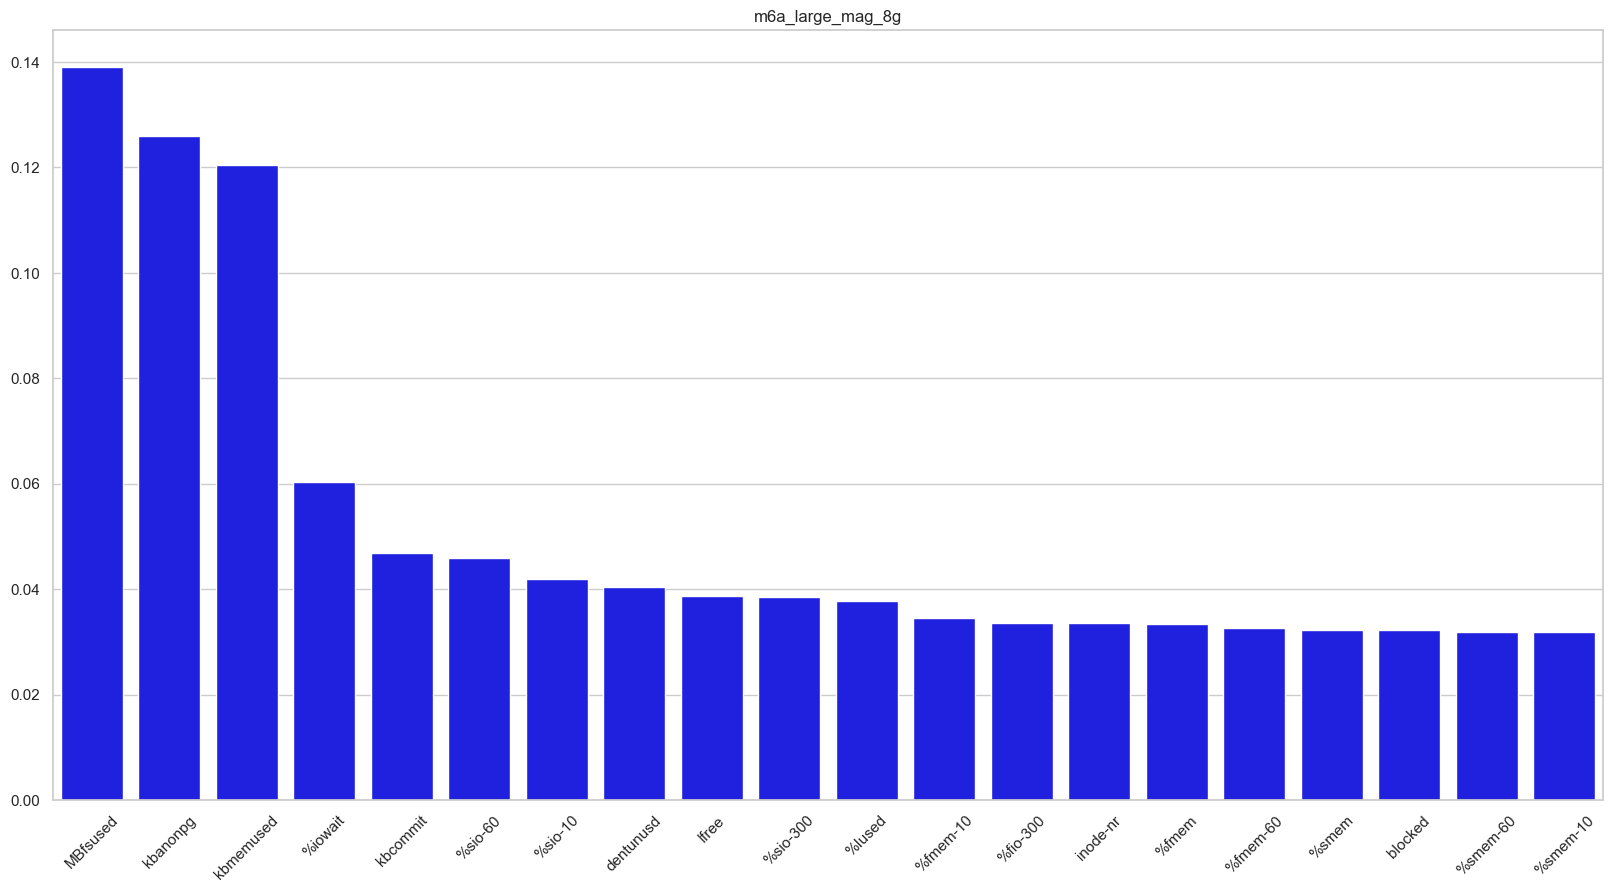

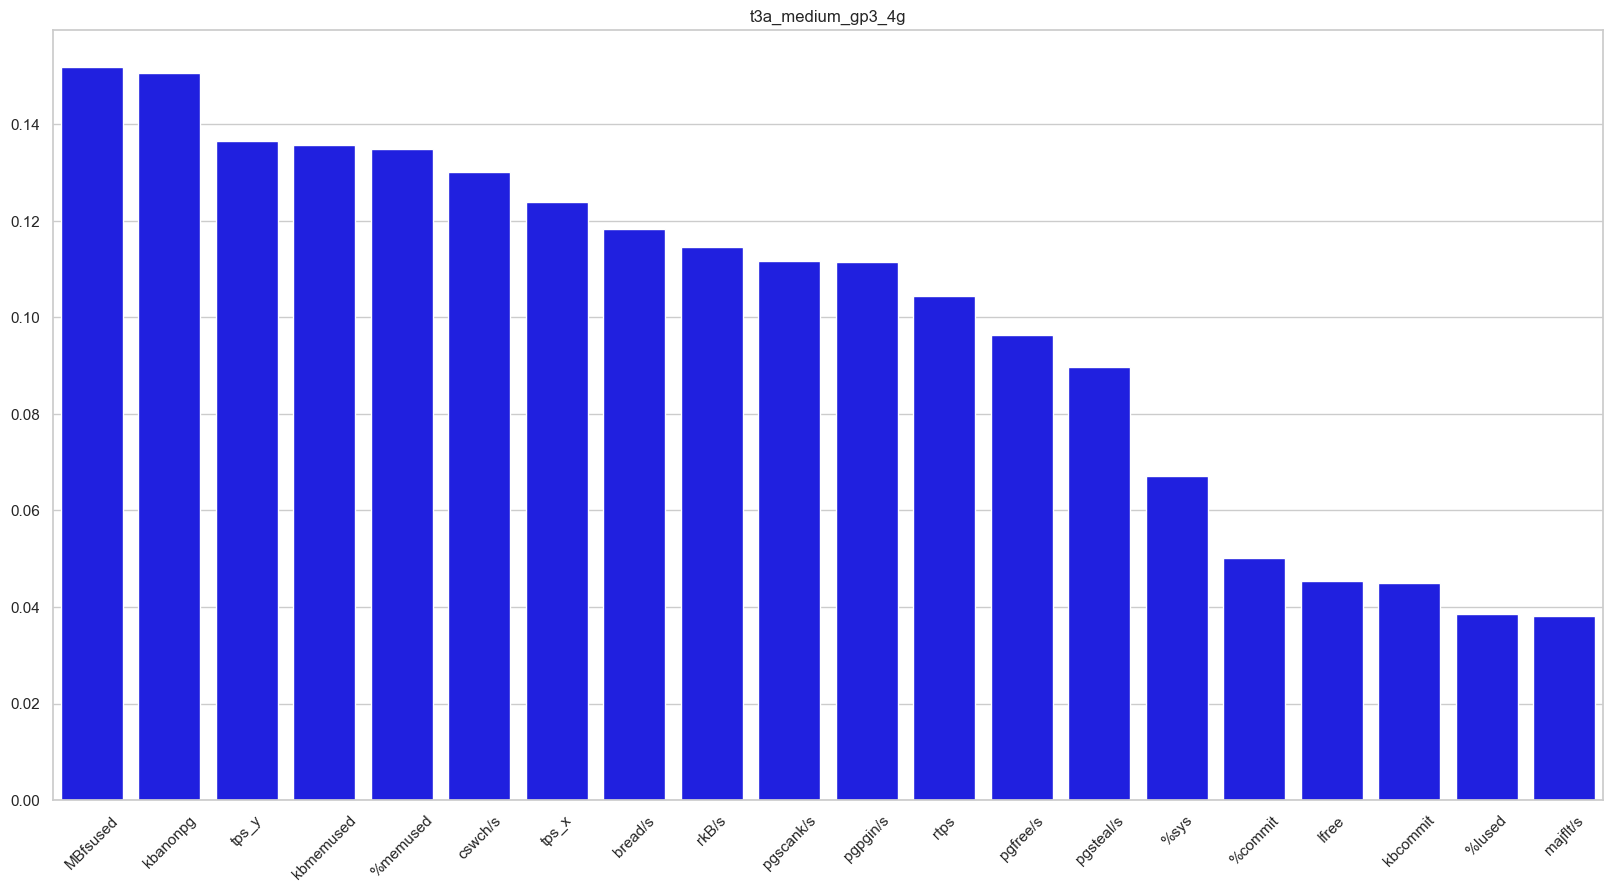

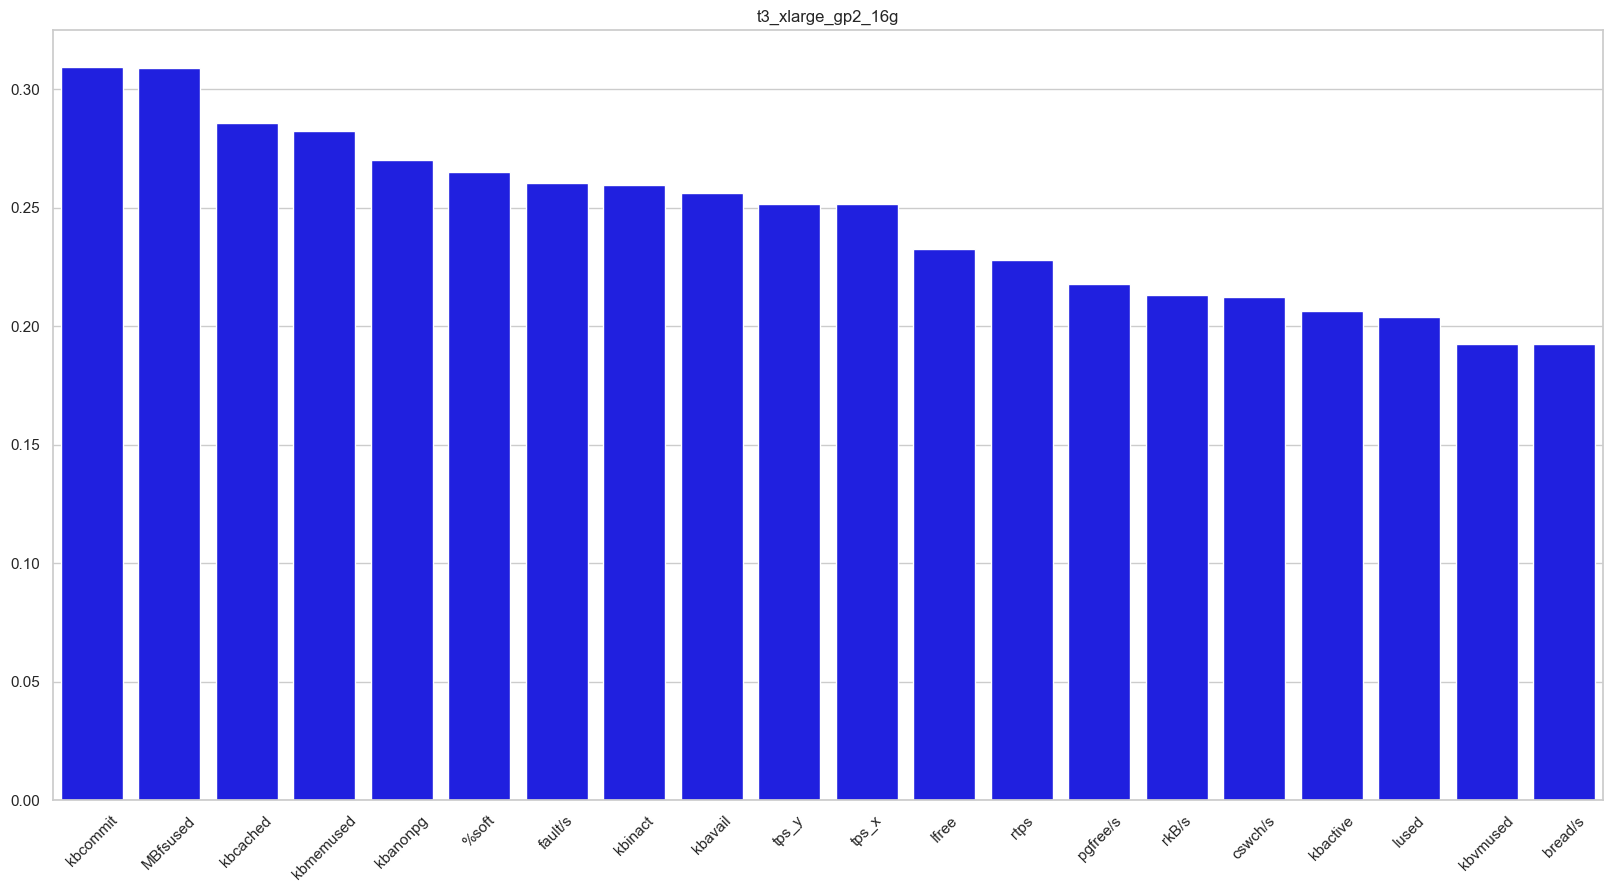

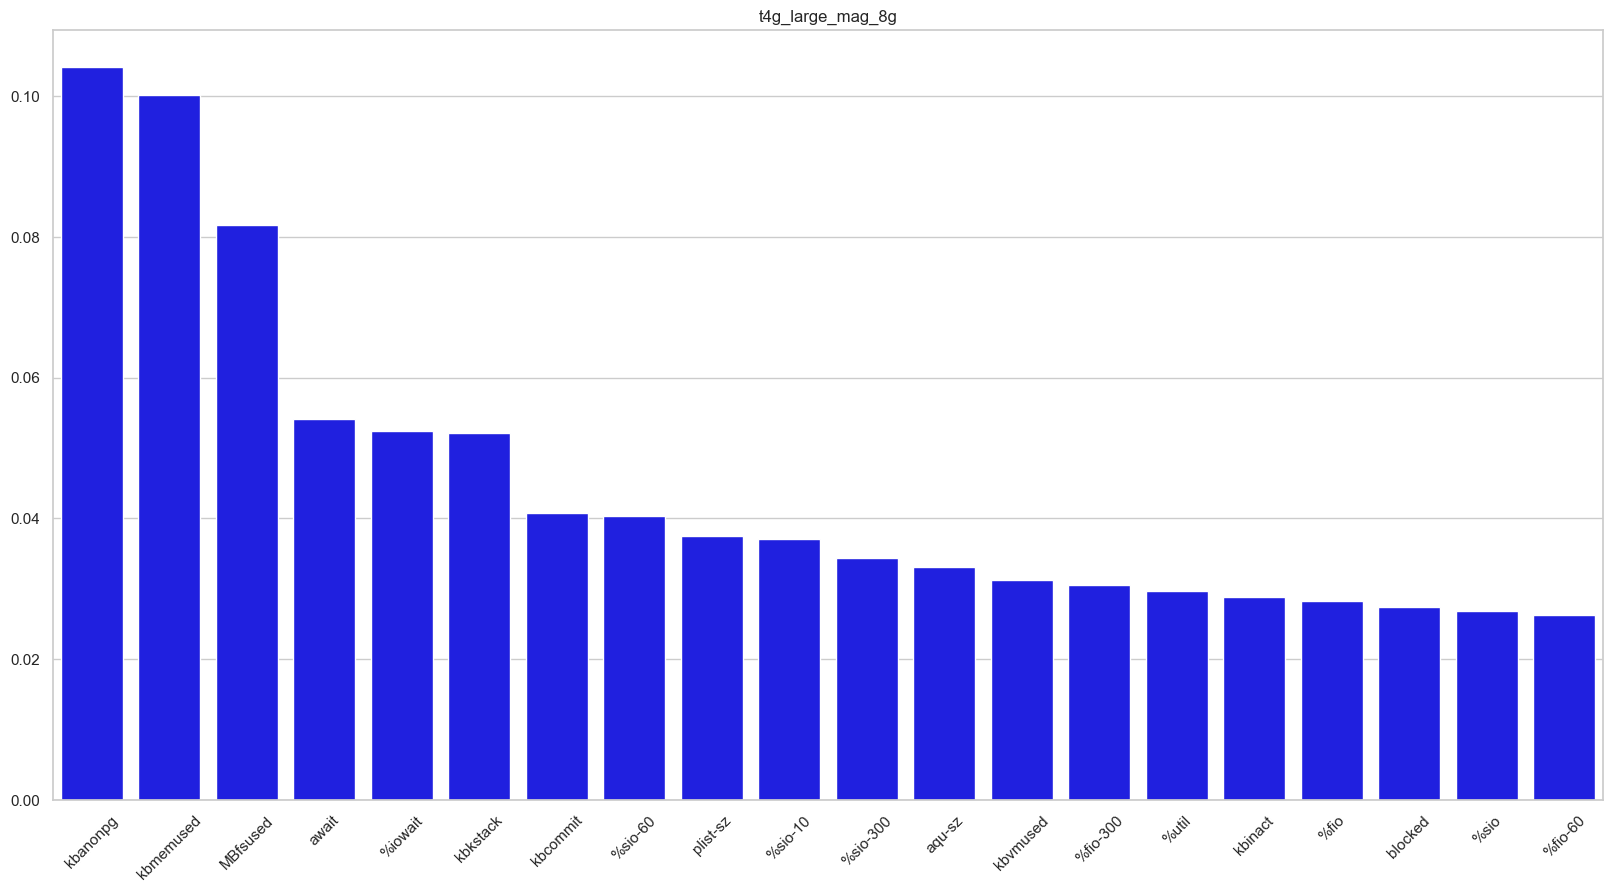

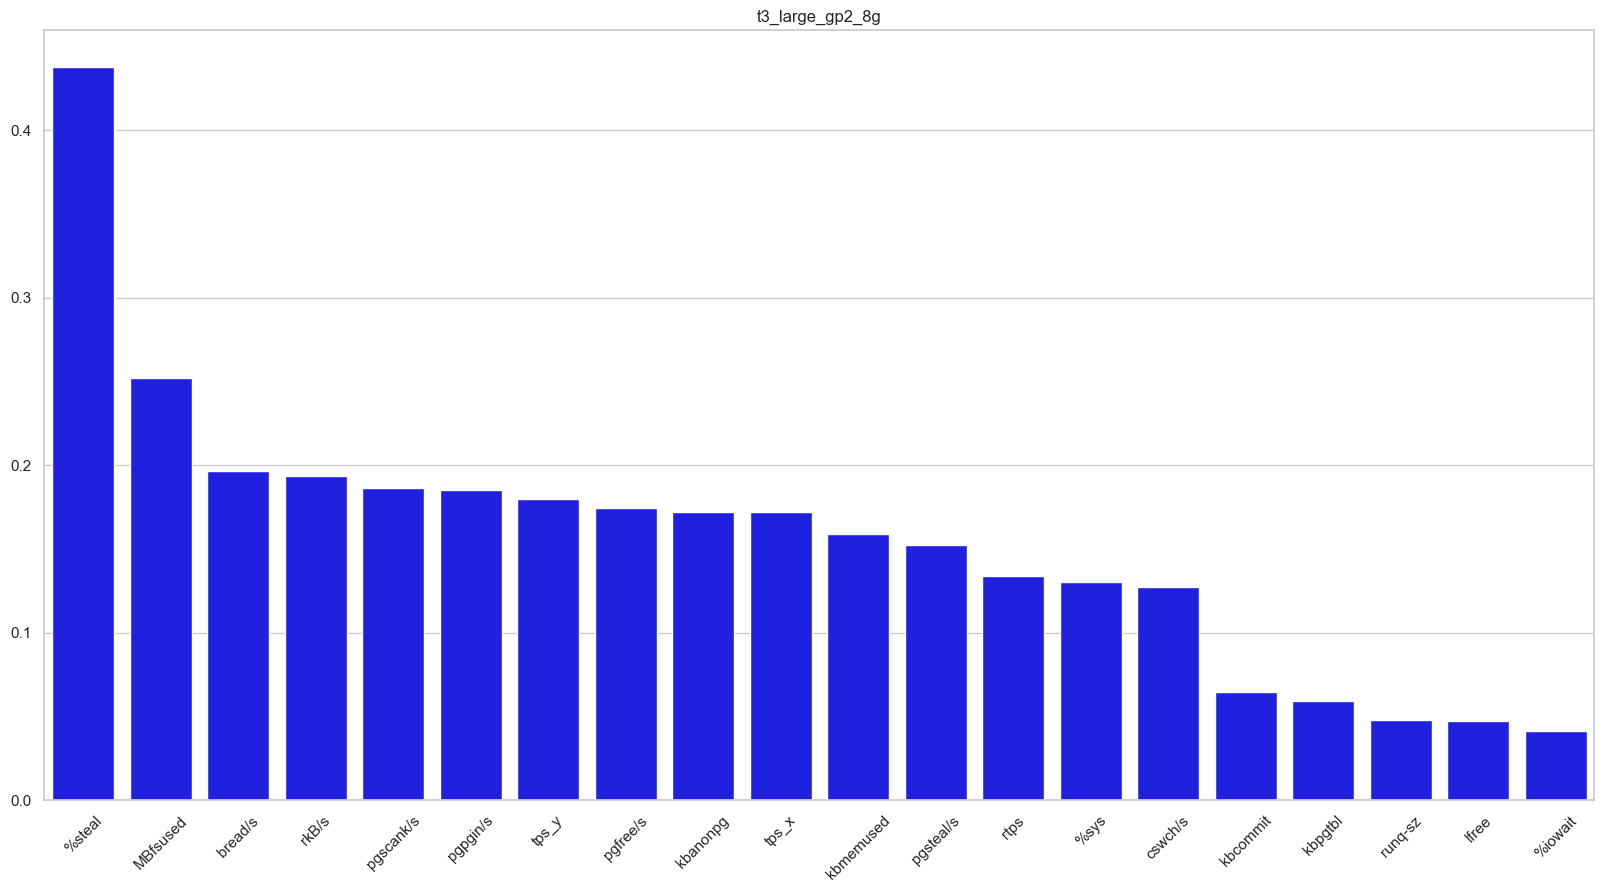

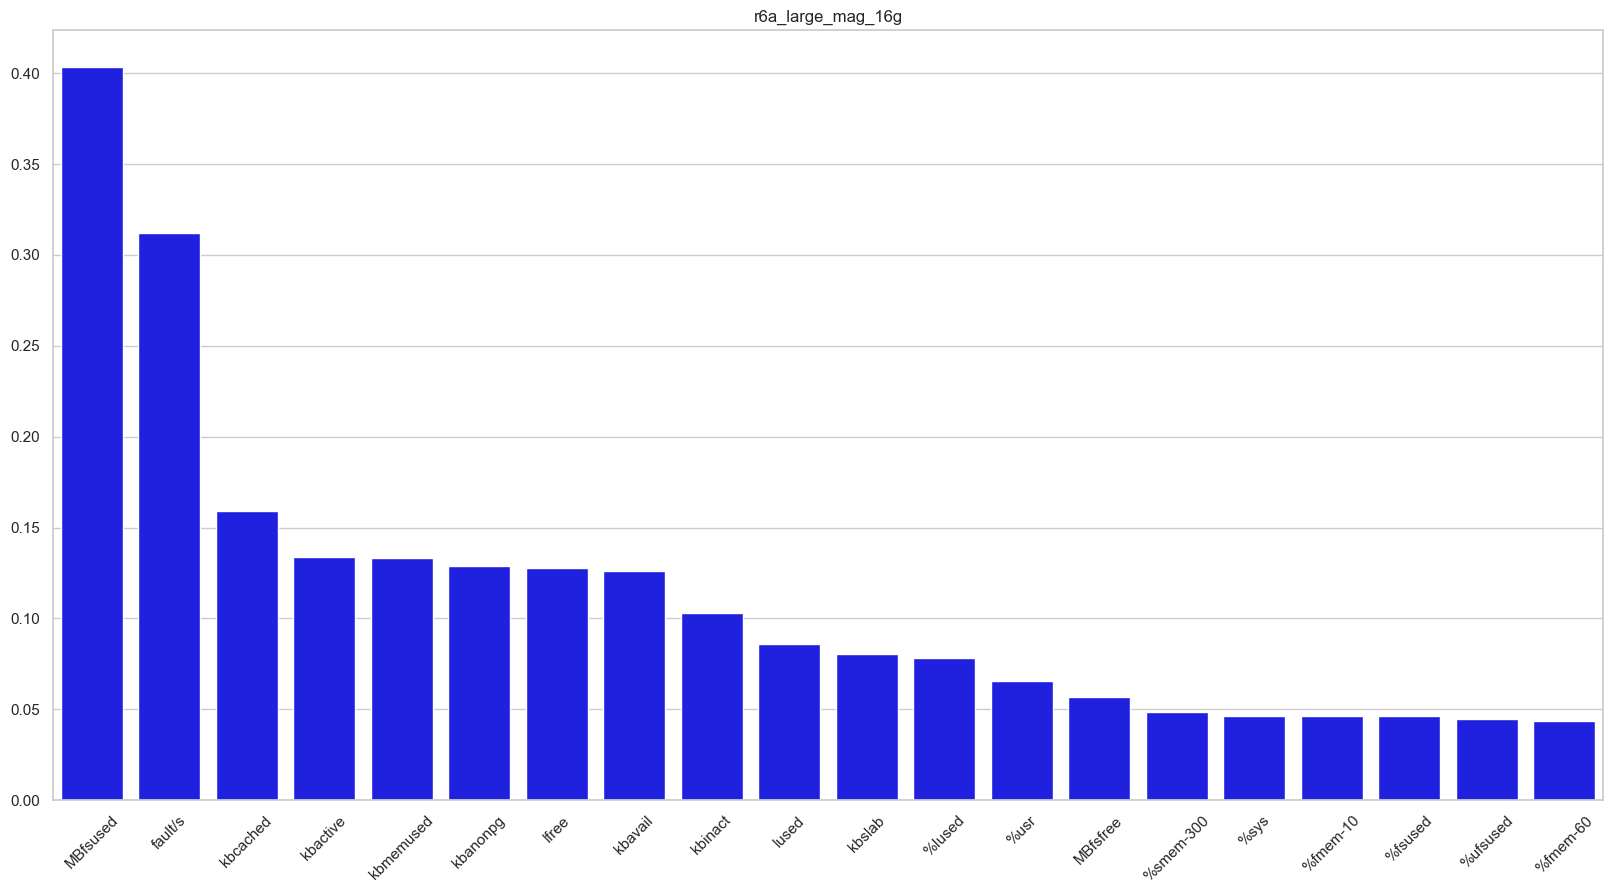

In [586]:
import seaborn as sns
import matplotlib.pyplot as plt

lttypes = set(logdf["lt_type"])

for lt in lttypes:
    tmp = logdf[logdf["lt_type"] == lt]

    # Sort the data by values and select the top 20
    sorted_tmp = tmp[key_names].mean().sort_values(ascending=False).head(20)

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 10))

    # Create a barplot for the top 20 values
    sns.barplot(x=sorted_tmp.index, y=sorted_tmp.values, color="blue")

    plt.title(lt)
    plt.xticks(rotation=45)

    plt.show()


In [232]:
print(set(logdf["%commit"]))
print(set(logdf["%smem-10"]))

{0.025472208857536316, 0.023860564455389977, 0.01557600125670433, 0.017588915303349495, 0.014569816179573536, 0.014808561652898788, 0.014942745678126812, 0.014975696802139282, 0.014845591969788074, 0.015282994136214256, 0.01545629370957613, 0.018087368458509445, 0.015455116517841816, 0.015412488952279091, 0.01581679657101631, 0.015934409573674202, 0.05758284404873848, 0.04345141723752022, 0.028066743165254593, 0.05664275959134102, 0.03178619220852852, 0.03280280902981758, 0.034109342843294144, 0.027296220883727074, 0.027854938060045242, 0.028079796582460403, 0.018454838544130325, 0.027587730437517166, 0.027845073491334915, 0.05277438834309578, 0.018497485667467117, 0.01500401645898819, 0.035917140543460846, 0.025226451456546783, 0.03713284432888031, 0.028099048882722855, 0.032832495868206024, 0.04588257521390915, 0.04083513841032982, 0.763616681098938, 0.025186657905578613, 0.9999982118606567, 0.017526449635624886, 0.02358359657227993, 0.0322502925992012, 0.026749499142169952, 0.027756

In [587]:
curatt = pickle.loads(df["att0"].values[0])

In [588]:
curatt.shape

(16, 92, 92)

In [589]:

# # Set up the matplotlib figure
# fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# # Iterate over each head and plot the attention matrix
# for i, ax in enumerate(axes.flat):
#     sns.heatmap(curatt[i], ax=ax, cmap='viridis', cbar=True)
#     ax.set_title(f'Head {i+1}')
#     ax.set_xlabel('Tokens')
#     ax.set_ylabel('Tokens')

# # Adjust layout for better visualization
# plt.tight_layout()
# plt.show()

In [590]:
#plot_all_heads(curatt)

In [591]:
curatt.shape

(16, 92, 92)

In [592]:
print(np.max(curatt[:,0,:]))
print(np.max(curatt[:,91,:]))

0.020456063
0.2599231


In [ ]:
key_names_tmp = []
for kn in key_names:
    if "tps_x" == kn:
        key_names_tmp.append("tps")
    elif "tps_y" == kn:
        key_names_tmp.append("tps-dev")
    else:
        key_names_tmp.append(kn)
key_names = key_names_tmp

In [593]:
df.groupby("qname")["latency"].std().reset_index().sort_values(by="latency", ascending=False)

qname     latency
64  cd252c4d15a8d118c1aae28bd1ec48c7f45584b2.sql  194.109152
15                                      2b92.sql  188.997185
6                                      2a245.sql  188.287348
36                                     5a850.sql  184.864717
28                                     4a178.sql  183.949742
..                                           ...         ...
21                                      3a76.sql   79.742444
50                                     7a165.sql   64.296947
19                                     3a411.sql   62.273740
18                                     3a315.sql   61.929322
54                                     8a121.sql   60.005305

[66 rows x 2 columns]

In [594]:
#tmp = df[df["lt_type"] != "t3_large_gp2_8g"]
tmp = df[df["lt_type"].str.contains("r6")]
tmp.groupby(["qname", "lt_type"])["latency"].std().reset_index().sort_values(by="latency", ascending=False).head(10)

qname            lt_type  \
10                                      2a67.sql  r6a_large_mag_16g   
33  4fbd39dcf5417c100e59a6f3759f1cc39fccb5c5.sql  r6a_large_mag_16g   
52                                      7a54.sql  r6a_large_mag_16g   
39                                     6a193.sql  r6a_large_mag_16g   
62  c5d8e041d0ccb8bb976fe1c1283ffba23613ac57.sql  r6a_large_mag_16g   
30                                     4a284.sql  r6a_large_mag_16g   
1                                     1a1506.sql  r6a_large_mag_16g   
13                                     2b190.sql  r6a_large_mag_16g   
47  77ed331843903f4ede8c87f6ac415ab4b963f573.sql  r6a_large_mag_16g   
43                                     6a423.sql  r6a_large_mag_16g   

       latency  
10  126.085185  
33   99.282069  
52   84.990188  
39   79.898830  
62   78.681344  
30   67.479980  
1    52.755153  
13   48.966573  
47   47.141036  
43   42.660279

In [595]:
# tmp = df[df["qname"] == "5a591.sql"]
# tmp = tmp[tmp["lt_type"] == "c5a_large_mag_4g"]

tmp = df[df["qname"] == "5a850.sql"]
tmp = tmp[tmp["lt_type"] == "r7g_large_gp2_16g"]
tmp = tmp.drop_duplicates("tag")
tmp = tmp.head(2)

# tmp = df[df["qname"] == "6a423.sql"]
# tmp = tmp[tmp["lt_type"].str.contains("r6")]
#tmp = tmp.drop_duplicates("tag")
#tmp = tmp.head(2)

In [596]:
tmp

instance            lt_type     latency      qname bk_kind  \
136  i-0a9d671f5b19f75e2  r7g_large_gp2_16g  450.987976  5a850.sql    None   
85   i-0fa2c87f5fce5a114  r7g_large_gp2_16g    0.843657  5a850.sql    None   

                                tag    start_time  \
136        exp8-stack-imdb-mixed-n3  1.701488e+09   
85   exp11-ceb-tpch-ergast-mixed-n3  1.701701e+09   

                                                  att0  \
136  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
85   b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   

                                             embedding  \
136  b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
85   b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   

                                                   avg  ...  pswpout/s  \
136  b"\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...   0.013406   
85   b"\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...   0.044514   

       pty-nr     rkB/s      rtps   runq-sz     tps_x     tps_y     wkB/s  \
136  0.011993  0.042939  0.034004  0.019143  0.041036  0.053247  0.012602   
85   0.022516  0.999997  0.999967  0.072156  1.000000  0.999999  0.018952   

         wtps  query_workload  
136  0.012772             CEB  
85   0.240403             CEB  

[2 rows x 103 columns]

In [670]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def get_logs(sample, key):
    logdfs = all_logdfs[sample["instance"]]
    for k,curdf in logdfs.items():
        if not key in curdf.keys():
            continue
        curdf = curdf[(curdf["timestamp"] >= sample["start_time"]) & \
                  (curdf["timestamp"] < sample["start_time"] + 600)]
        
        #rows_to_drop = curdf.index[::2]
        # Drop these rows
        #curdf = curdf.drop(rows_to_drop)

        return curdf[key].values

# Function to get indices of top n values in a 2D array
def get_top_n_indices(matrix, n):
    flat_indices = np.argpartition(matrix.ravel(), -n)[-n:]
    return np.array(np.unravel_index(flat_indices, matrix.shape)).T

def plot_all_heads(curatt, key_names):
    # Set up the matplotlib figure
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    # Iterate over each head and plot the attention matrix
    for i, ax in enumerate(axes.flat):
        # Get top 5 attention scores for the current head
        top_5_indices = get_top_n_indices(curatt[i], 5)

        # Create the heatmap
        sns.heatmap(curatt[i], ax=ax, cmap='viridis', cbar=True)

        # Set labels for top 5 rows and columns
        top_rows = np.unique(top_5_indices[:, 0])
        top_cols = np.unique(top_5_indices[:, 1])

        # Label the top 5 rows
        ax.set_yticks(top_rows + 0.5)  # +0.5 to center labels
        ax.set_yticklabels([key_names[row] for row in top_rows], rotation=0)  # Vertical y-axis labels

        # Label the top 5 columns
        ax.set_xticks(top_cols + 0.5)  # +0.5 to center labels
        ax.set_xticklabels([key_names[col] for col in top_cols], rotation=45, ha="right")

        # Set title
        ax.set_title(f'Head {i+1}')
        
    # Adjust layout
    plt.tight_layout()
    
    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_top_n_indices(matrix, n):
    # Assuming this function is already defined to get the indices of the top n values
    flat_indices = np.argpartition(matrix.ravel(), -n)[-n:]
    return np.array(np.unravel_index(flat_indices, matrix.shape)).T

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_top_n_indices(matrix, n):
    # Assuming this function is already defined to get the indices of the top n values
    flat_indices = np.argpartition(matrix.ravel(), -n)[-n:]
    return np.array(np.unravel_index(flat_indices, matrix.shape)).T

def plot_combined_heads(curatt1, curatt2, key_names):
    # Set up the matplotlib figure, adjusted size for a LaTeX article column
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # Smaller figure size for half a LaTeX article

    # Adjust font size for tick labels
    label_fontsize = 8  # Set a smaller font size for labels

    # Iterate over first two heads of curatt1
    for i in range(2):
        ax = axes[0, i]
        top_5_indices = get_top_n_indices(curatt1[i], 5)
        sns.heatmap(curatt1[i], ax=ax, cmap='viridis', cbar=True)

        top_rows = np.unique(top_5_indices[:, 0])
        top_cols = np.unique(top_5_indices[:, 1])

        ax.set_yticks(top_rows + 0.5)
        ax.set_yticklabels([key_names[row] for row in top_rows], rotation=0, fontsize=label_fontsize)

        ax.set_xticks(top_cols + 0.5)
        ax.set_xticklabels([key_names[col] for col in top_cols], rotation=45, ha="right", fontsize=label_fontsize)

    # Iterate over first two heads of curatt2
    for i in range(2):
        ax = axes[1, i]
        top_5_indices = get_top_n_indices(curatt2[i], 5)
        sns.heatmap(curatt2[i], ax=ax, cmap='viridis', cbar=True)

        top_rows = np.unique(top_5_indices[:, 0])
        top_cols = np.unique(top_5_indices[:, 1])

        ax.set_yticks(top_rows + 0.5)
        ax.set_yticklabels([key_names[row] for row in top_rows], rotation=0, fontsize=label_fontsize)

        ax.set_xticks(top_cols + 0.5)
        ax.set_xticklabels([key_names[col] for col in top_cols], rotation=45, ha="right", fontsize=label_fontsize)

    plt.tight_layout()
    plt.savefig("combined-heads.pdf", bbox_inches="tight")


def plot_all_logs(keys, row):
    # Set up a 4x4 grid of plots
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    # Iterate over the first 16 keys and plot in the grid
    for i, key in enumerate(keys[:16]):
        logs = get_logs(row, key)
        sns.lineplot(data=logs, ax=axes[i])
        axes[i].set_title(key)

    # Adjust layout
    plt.tight_layout()
    #plt.show()


In [671]:
all_keys = []
for idx,row in tmp.iterrows():
    curatt = pickle.loads(row["att0"])
    #print(row["lt_type"], row["latency"])
    top_keys = []
    for atti in range(curatt.shape[0]):
        top_5_indices = get_top_n_indices(curatt[atti], 4)
        top_rows = np.unique(top_5_indices[:, 0])
        top_cols = np.unique(top_5_indices[:, 1])
        keys = [k for k in top_rows]
        keys += [k for k in top_cols]
        top_keys += keys
        
    top_keys = list(set(top_keys))
    top_keys = [key_names[ki] for ki in top_keys]
    all_keys += top_keys
    #plot_all_logs(top_keys, rows)
    #plot_all_heads(curatt, key_names)
    
all_keys = list(set(all_keys))
print(len(all_keys))
all_keys

36


['fault/s',
 'kbinact',
 'ldavg-15',
 'kbcached',
 'majflt/s',
 'rkB/s',
 'pgfree/s',
 '%smem-300',
 'pgscank/s',
 '%idle',
 'kbslab',
 'bwrtn/s',
 '%memused',
 '%sio-300',
 'intr/s',
 'wtps',
 'kbanonpg',
 'await',
 '%smem-60',
 'runq-sz',
 '%irq',
 '%sys',
 'aqu-sz',
 '%gnice',
 'kbavail',
 '%scpu',
 'tps-dev',
 '%fmem-60',
 'pgscand/s',
 'kbmemused',
 '%commit',
 'kbvmused',
 'pgpgin/s',
 '%usr',
 'dentunusd',
 'bread/s']

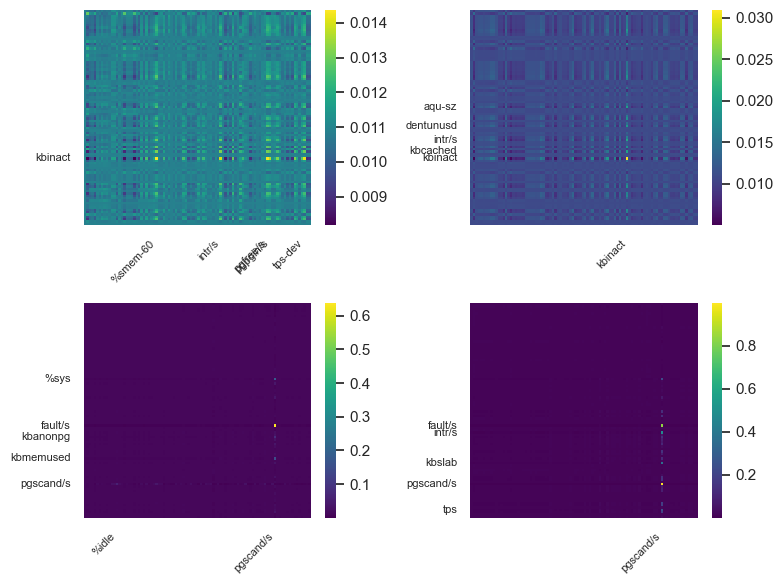

In [672]:
curatt1 = pickle.loads(tmp["att0"].values[0])
curatt2 = pickle.loads(tmp["att0"].values[1])
plot_combined_heads(curatt1, curatt2, key_names)

In [636]:
for idx, row in tmp.iterrows():
    curatt = pickle.loads(row["att0"])
    print(row["lt_type"], row["latency"])

    # Your existing plotting code
#     plot_all_logs(all_keys[0:16], row)
#     plot_all_logs(all_keys[16:32], row)
    plot_all_heads(curatt, key_names)

r7g_large_gp2_16g 450.9879760742188



KeyboardInterrupt



Error in callback <function flush_figures at 0x13a139090> (for post_execute):


KeyboardInterrupt: 

In [601]:
from collections import defaultdict

label_data = {}
for key in all_keys:
    label_data[key] = {}

for idx, row in tmp.iterrows():
    sample_name = row["tag"] + str(row["start_time"])
    
    for i, key in enumerate(all_keys):
        logs = get_logs(row, key)
        label_data[key][sample_name] = logs

In [602]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'label_data' is your dictionary
# # label_data = your_data

# # Number of plots per figure (4x4 grid)
# plots_per_figure = 16

# # Initialize lists to collect legend handles and labels
# legend_handles = []
# legend_labels = set()

# # Creating subplots for each figure
# for i, k in enumerate(label_data.keys()):
#     if i % plots_per_figure == 0:
#         fig, axes = plt.subplots(4, 4, figsize=(20, 20))
#         fig.subplots_adjust(hspace=0.4, wspace=0.4)

#     ax = axes[i // 4 % 4, i % 4]

#     # Convert to DataFrame; adjust as per your data's structure
#     curdf = pd.DataFrame(label_data[k])
#     lines = sns.lineplot(data=curdf, ax=ax)

#     # Collect handles and labels for the legend
#     for line in lines.get_lines():
#         label = line.get_label()
#         if label not in legend_labels:
#             legend_handles.append(line)
#             legend_labels.add(label)

#     ax.set_title(k)

#     if (i + 1) % plots_per_figure == 0 or i == len(label_data) - 1:
#         fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', ncol=4)
#         plt.show()
#         # Reset legend handles and labels for the next figure
#         legend_handles = []
#         legend_labels = set()


In [657]:
all_keys

keys_to_plot = ['pgscand/s', 'await', 'runq-sz', '%usr' , 
                'dentunusd', 'kbinact', 'kbcached', '%smem-300',
                '%sio-300', 'fault/s', 'pgfree/s', 'intr/s', 
               ]

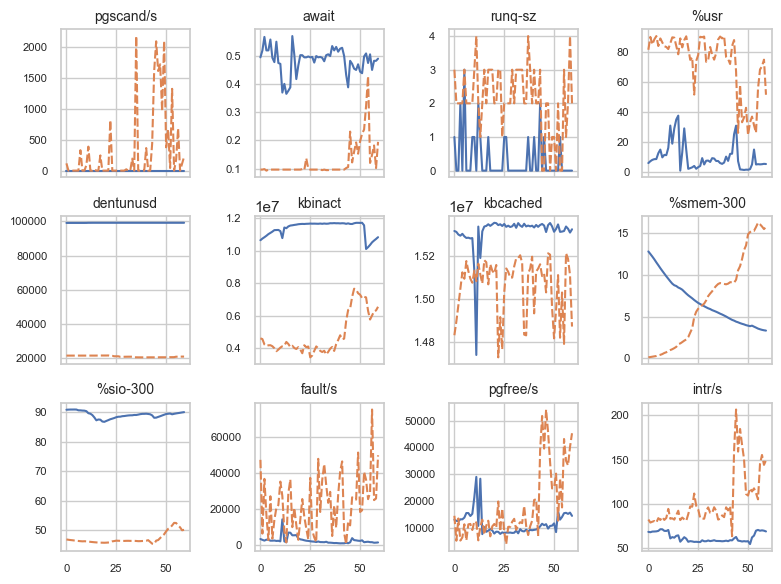

In [660]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label_data' and 'keys_to_plot' are defined
# keys_to_plot = list(label_data.keys()) # If 'keys_to_plot' is not already defined

# Define the size of the entire figure
fig, axes = plt.subplots(3, 4, figsize=(8, 6))  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop over keys and plot
for i, k in enumerate(keys_to_plot):
    if i >= 12:  # Only plot the first 12 keys
        break

    try:
        curdf = pd.DataFrame(label_data[k])
        sns.lineplot(data=curdf, ax=axes[i])
        axes[i].set_title(k, fontsize=10)  # Smaller title font size
        axes[i].tick_params(axis='y', labelsize=8)  # Smaller y-tick labels

        # Remove x-tick labels for all except the third row
        if i < 8:  # Adjust this condition based on your layout
            axes[i].tick_params(axis='x', labelsize=8, labelbottom=False)
        else:
            axes[i].tick_params(axis='x', labelsize=8)

        axes[i].legend().remove()

    except Exception as e:
        print(f"Error plotting {k}: {e}")
        continue

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig("SysLogs-Combined-Analysis.pdf", bbox_inches="tight")
# Show the plot
plt.show()


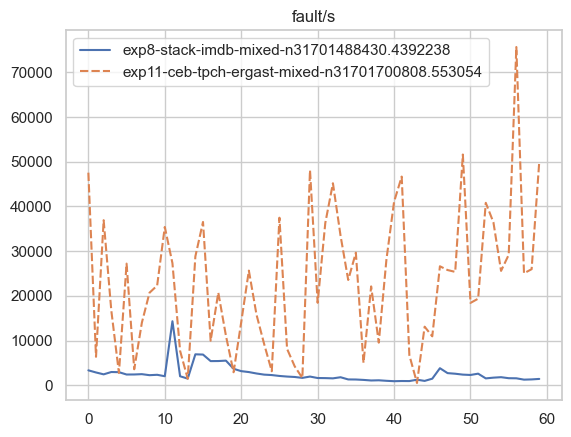

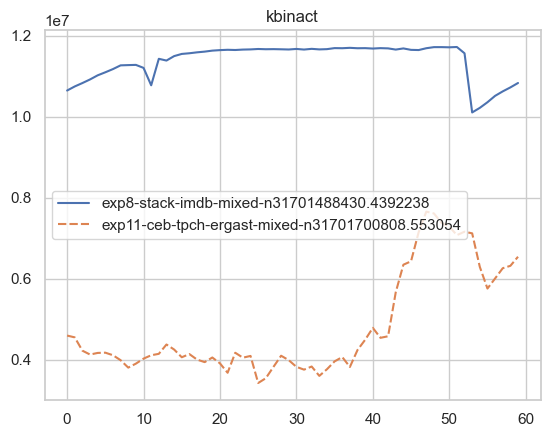

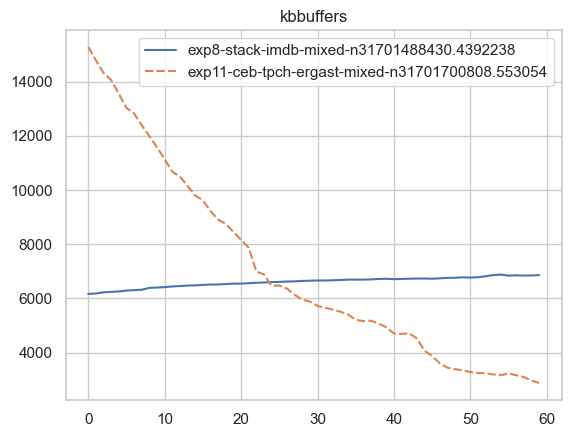

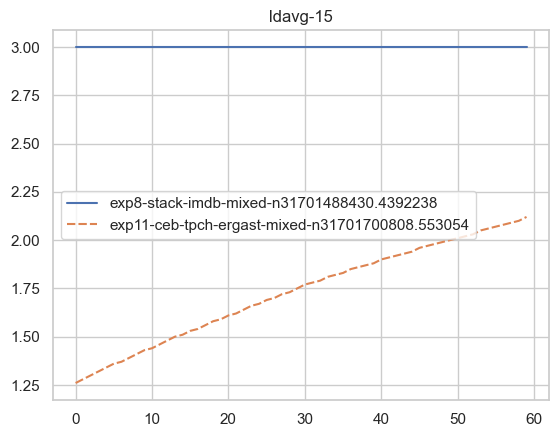

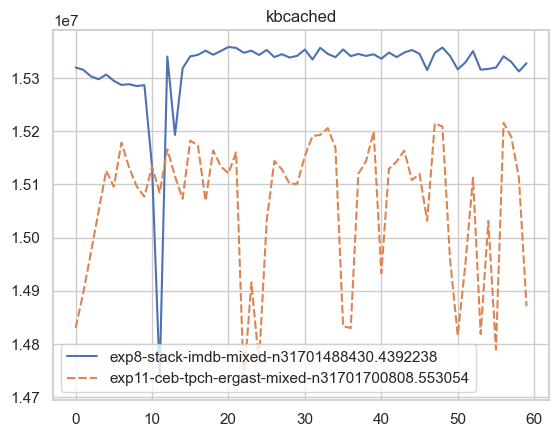

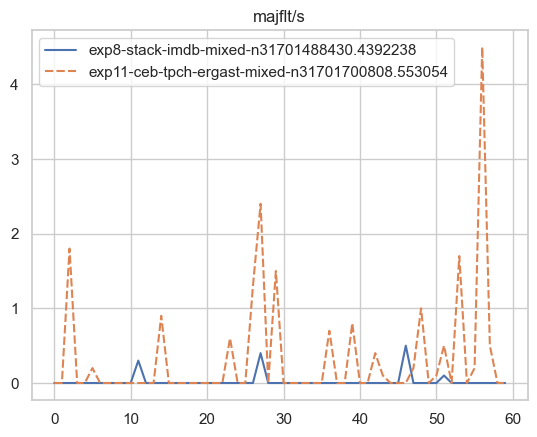

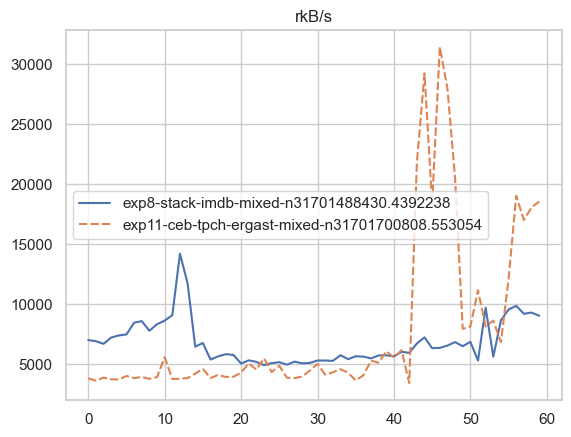

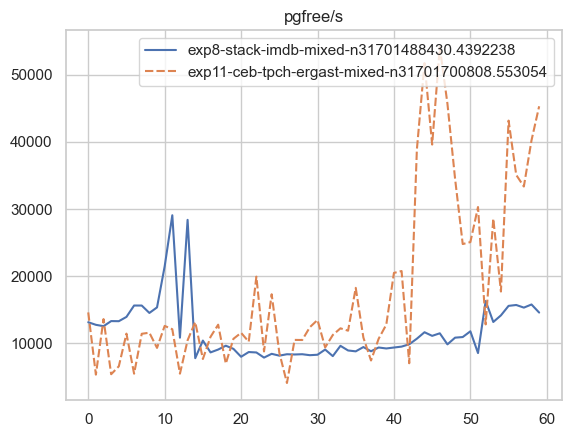

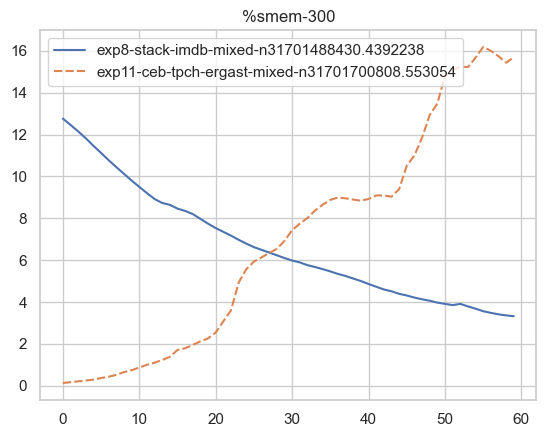

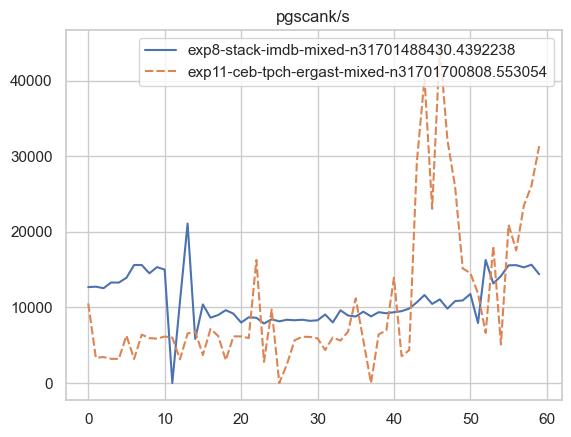

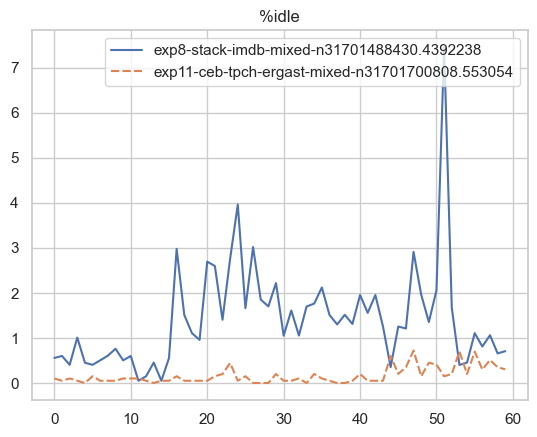

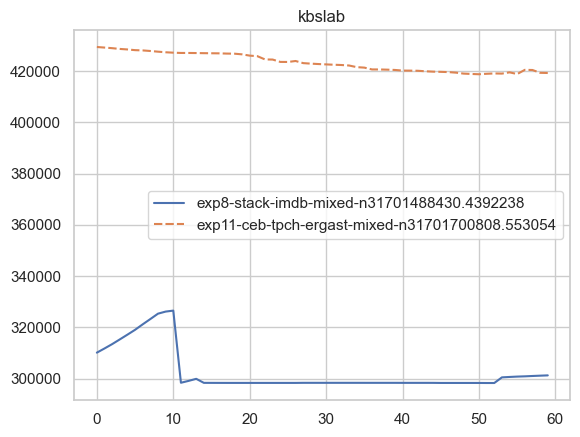

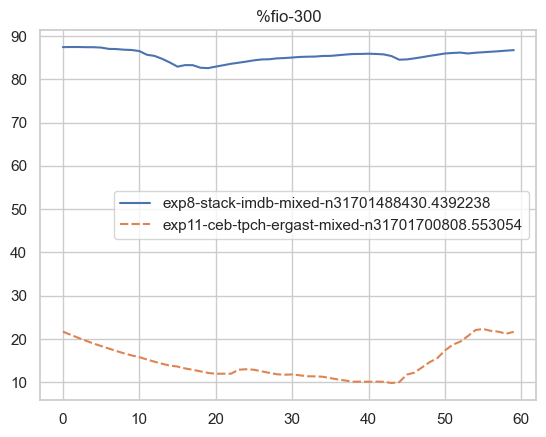

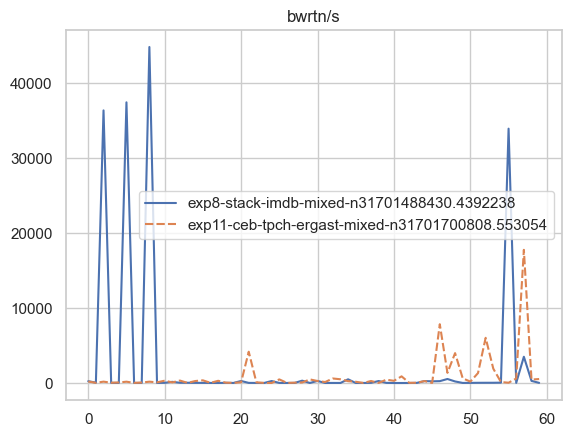

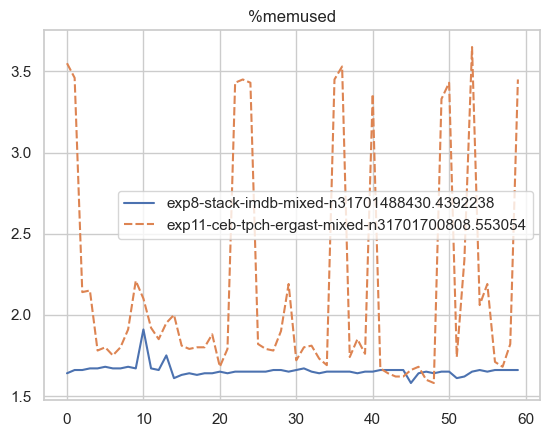

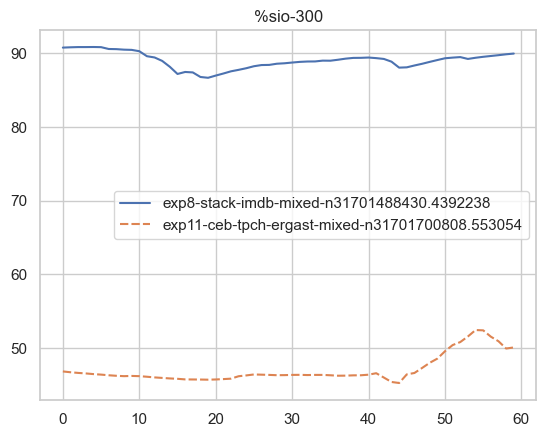

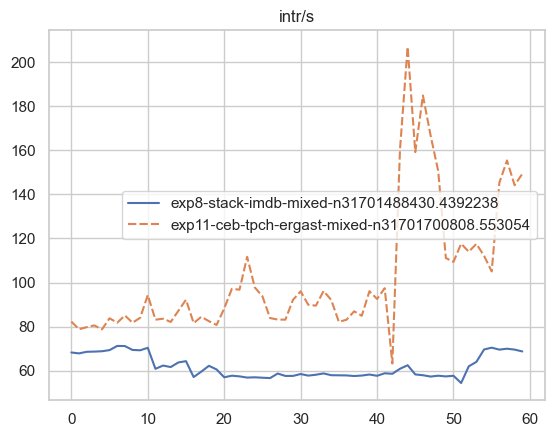

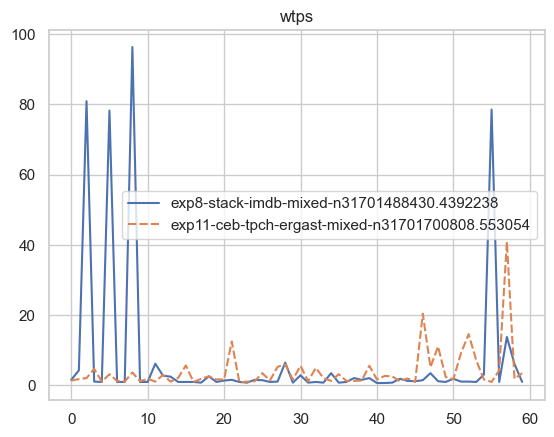

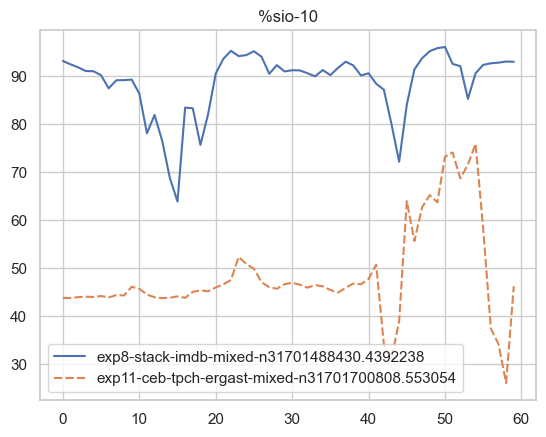

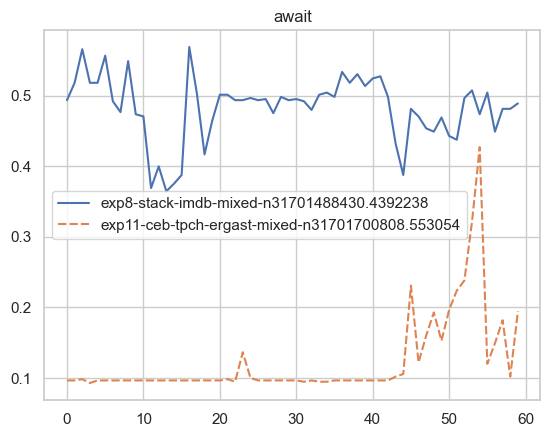

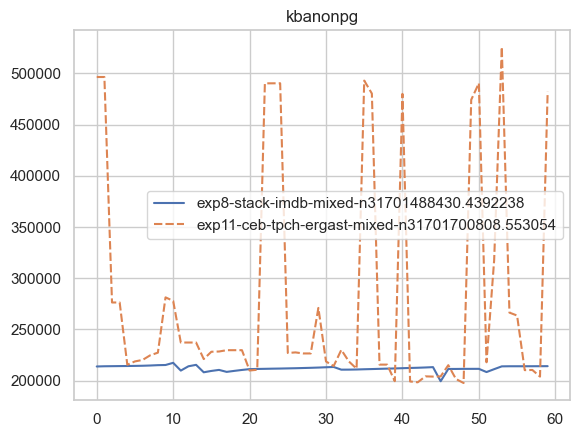

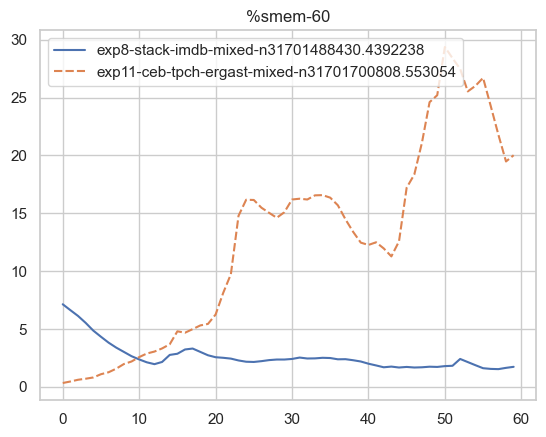

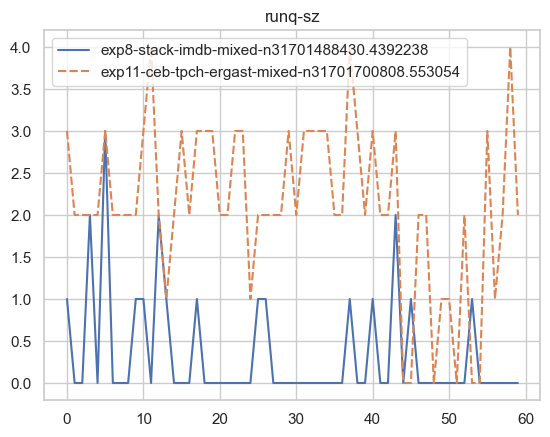

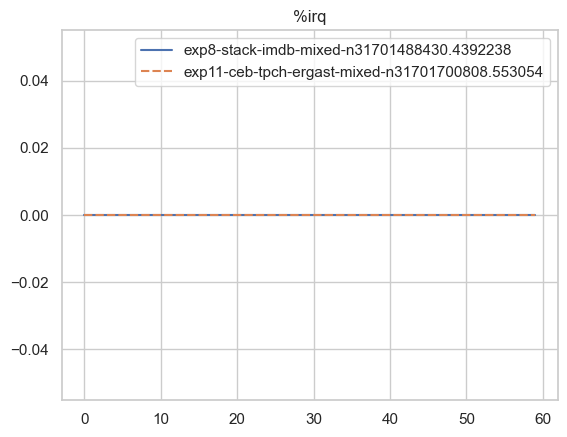

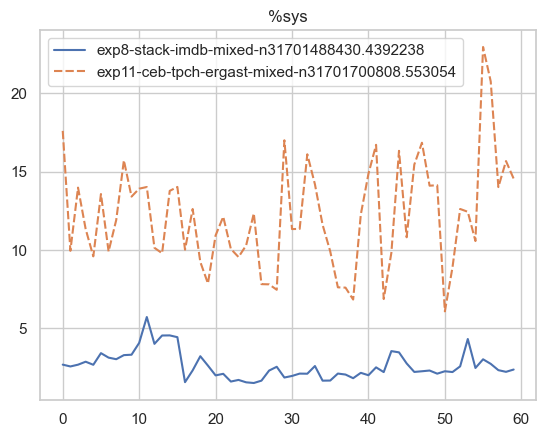

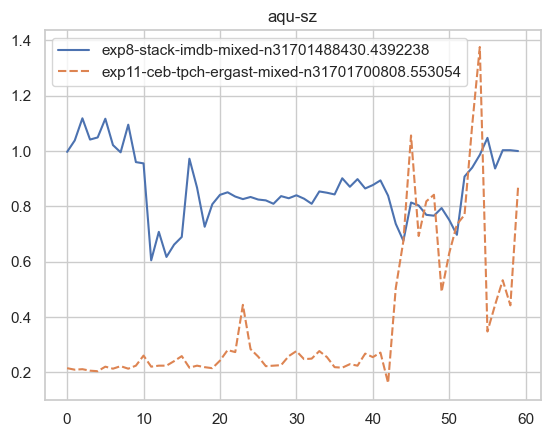

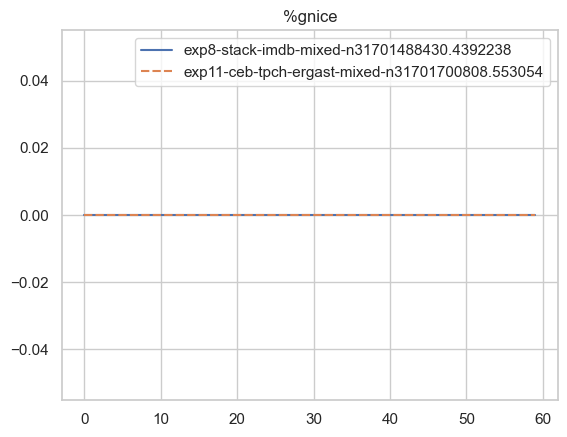

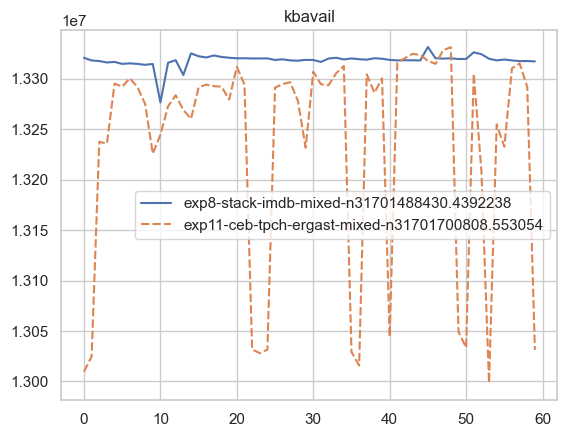

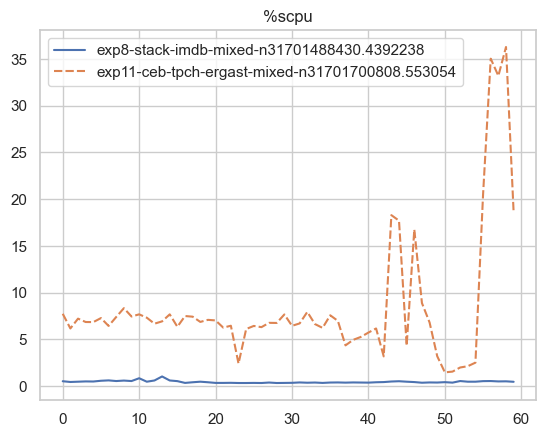

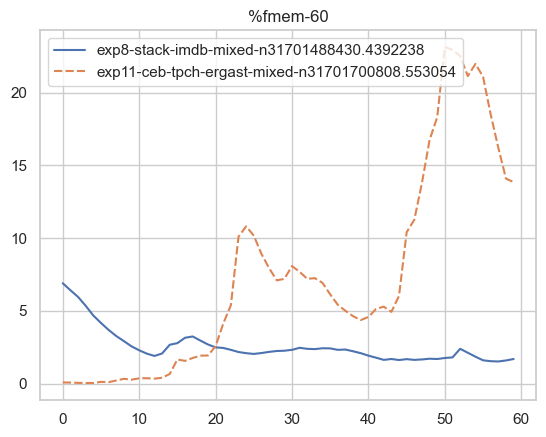

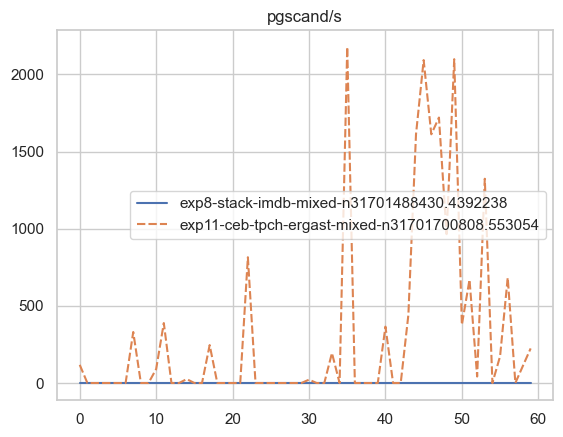

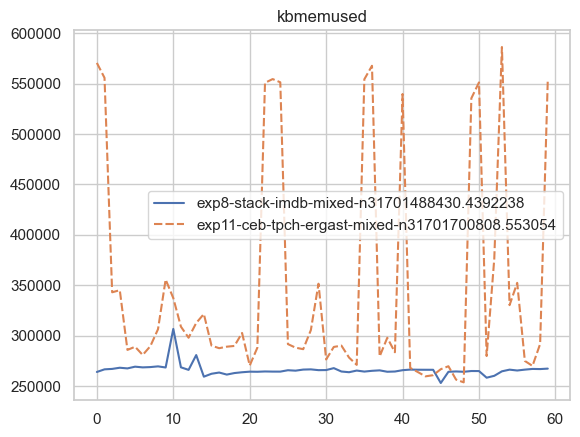

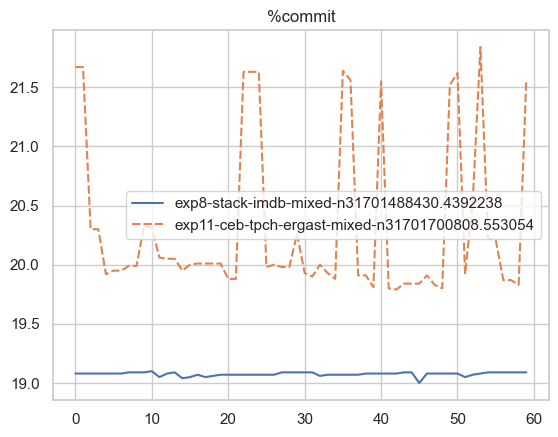

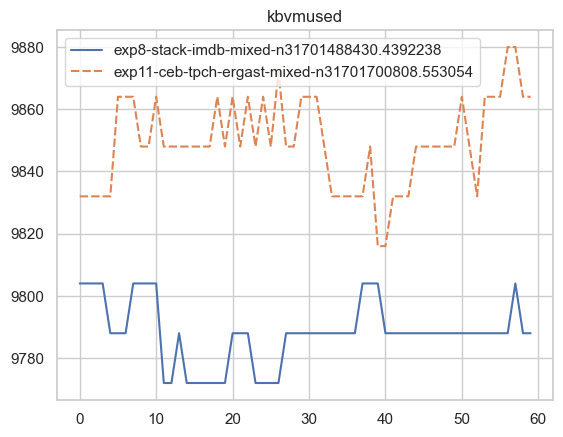

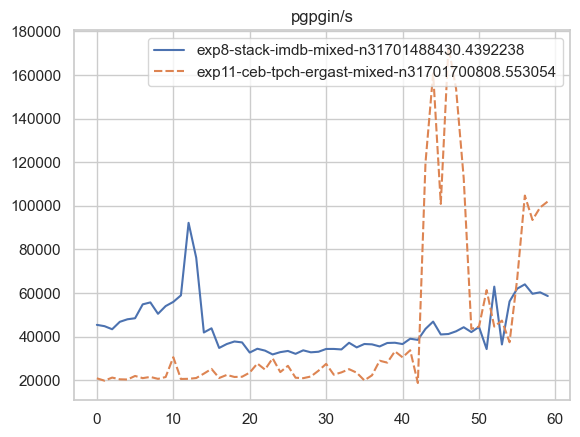

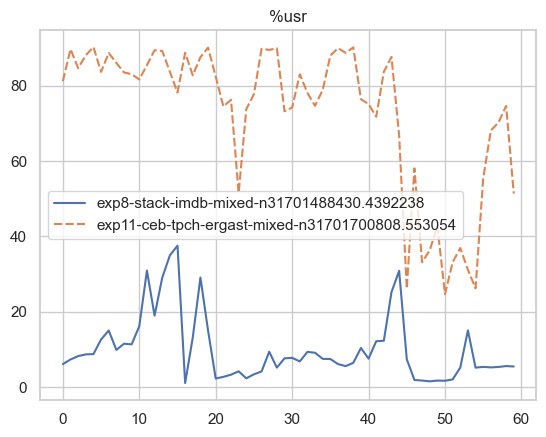

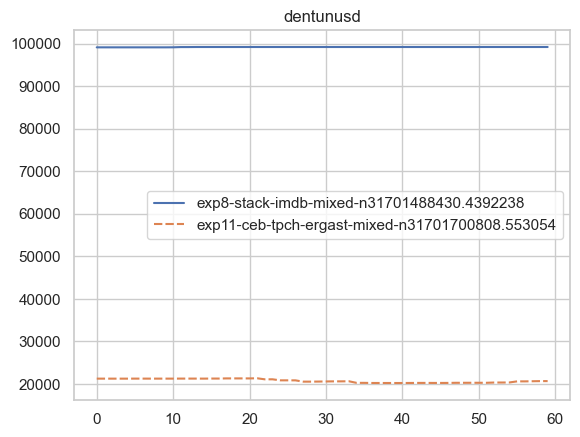

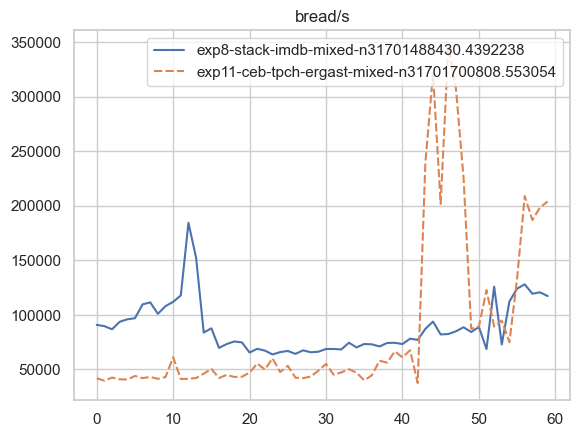

In [603]:
for k in label_data:
    try:
        curdf = pd.DataFrame(label_data[k])
        sns.lineplot(curdf)
        plt.title(k)
        plt.show()
    except:
        continue

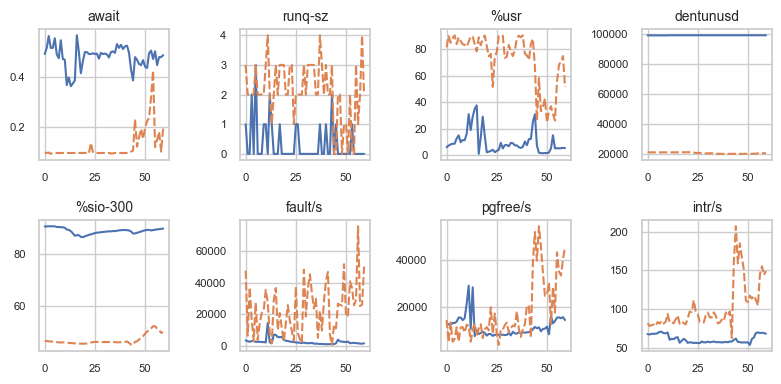

In [319]:
tmp

instance            lt_type     latency      qname bk_kind  \
136  i-0a9d671f5b19f75e2  r7g_large_gp2_16g  450.987976  5a850.sql    None   
147  i-0a9d671f5b19f75e2  r7g_large_gp2_16g    1.215798  5a850.sql    None   

                          tag    start_time  \
136  exp8-stack-imdb-mixed-n3  1.701488e+09   
147  exp8-stack-imdb-mixed-n3  1.701491e+09   

                                                  att0  \
136  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
147  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   

                                             embedding    %Iused  ...  \
136  b'\x80\x04\x95\x8e\x80\x00\x00\x00\x00\x00\x00...  0.028754  ...   
147  b'\x80\x04\x95\x8e\x80\x00\x00\x00\x00\x00\x00...  0.022988  ...   

     pswpin/s  pswpout/s    pty-nr     rkB/s      rtps   runq-sz     tps_x  \
136  0.011694   0.013406  0.011993  0.042939  0.034004  0.019143  0.041036   
147  0.011607   0.012753  0.011670  0.011836  0.019459  0.014422  0.023101   

        tps_y     wkB/s      wtps  
136  0.053247  0.012602  0.012772  
147  0.027863  0.012368  0.012411  

[2 rows x 101 columns]

# Embeddings

In [486]:
df

instance            lt_type     latency  \
0   i-0ba5474ed648606a8   t4g_large_mag_8g    6.740750   
1   i-0ba5474ed648606a8   t4g_large_mag_8g  195.985034   
2   i-0ba5474ed648606a8   t4g_large_mag_8g  407.695811   
3   i-0ba5474ed648606a8   t4g_large_mag_8g  876.877110   
4   i-0ba5474ed648606a8   t4g_large_mag_8g  401.329551   
..                  ...                ...         ...   
49  i-0fa2c87f5fce5a114  r7g_large_gp2_16g    6.938538   
50  i-0fa2c87f5fce5a114  r7g_large_gp2_16g    0.621878   
51  i-0fa2c87f5fce5a114  r7g_large_gp2_16g    0.149262   
52  i-0fa2c87f5fce5a114  r7g_large_gp2_16g    0.617420   
53  i-0fa2c87f5fce5a114  r7g_large_gp2_16g    0.684905   

                                           qname bk_kind  \
0                                      4a398.sql    None   
1                                      7a131.sql    None   
2                                      2a620.sql    None   
3                                      4a143.sql    None   
4   45c669fe5625a11ad100e6a20d915119b8d56c54.sql    None   
..                                           ...     ...   
49  6de21f7b6d08d84073c7496dbff73afba95d7c8d.sql    None   
50  3ebf44254fc9a2ae77481169131fd0ab111a6c43.sql    None   
51                                     3a848.sql    None   
52                                    1a2442.sql    None   
53  05d86a8dd0274da78805545a176079f8e14f7e7d.sql    None   

                               tag    start_time  \
0   exp11-ceb-tpch-ergast-mixed-n3  1.701700e+09   
1   exp11-ceb-tpch-ergast-mixed-n3  1.701700e+09   
2   exp11-ceb-tpch-ergast-mixed-n3  1.701701e+09   
3   exp11-ceb-tpch-ergast-mixed-n3  1.701702e+09   
4   exp11-ceb-tpch-ergast-mixed-n3  1.701703e+09   
..                             ...           ...   
49  exp11-ceb-tpch-ergast-mixed-n3  1.701720e+09   
50  exp11-ceb-tpch-ergast-mixed-n3  1.701720e+09   
51  exp11-ceb-tpch-ergast-mixed-n3  1.701720e+09   
52  exp11-ceb-tpch-ergast-mixed-n3  1.701720e+09   
53  exp11-ceb-tpch-ergast-mixed-n3  1.701720e+09   

                                                 att0  \
0   b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
1   b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
2   b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
3   b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
4   b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
..                                                ...   
49  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
50  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
51  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
52  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   
53  b'\x80\x04\x95\x85\x00\x00\x00\x00\x00\x00\x00...   

                                            embedding  \
0   b"\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
1   b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
2   b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
3   b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
4   b"\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
..                                                ...   
49  b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
50  b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
51  b"\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
52  b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   
53  b'\x80\x04\x95\x08\x01\x00\x00\x00\x00\x00\x00...   

                                                  avg  ...    pty-nr  \
0   b'\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...  0.013901   
1   b'\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...  0.013632   
2   b'\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...  0.014609   
3   b"\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...  0.012857   
4   b'\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...  0.011978   
..                                                ...  ...       ...   
49  b'\x80\x04\x95\xfb\x01\x00\x00\x00\x00\x00\x00...  ...  0.013315   
50  b'\x80\x04\x95\xfb\x01

In [673]:
embeds = []
tags = []
avgs = []

for idx,row in df.iterrows():
    emb = pickle.loads(row["embedding"])
    #print(emb.shape)
    avg = pickle.loads(row["avg"])
    embeds.append(emb)
    avgs.append(avg)
    tags.append(row["tag"])

embeds = np.array(embeds)
avgs = np.array(avgs)

print(embeds.shape)
print(avgs.shape)

(2993, 32)
(2993, 92)


In [674]:
embeds

array([[ 0.8081731 , -0.58860654, -0.7975041 , ...,  0.5511965 ,
        -0.9161648 ,  0.56262016],
       [ 0.5706701 , -0.3627775 , -0.809024  , ...,  0.33238965,
        -0.8318927 ,  0.33546725],
       [ 0.5828968 , -0.36661592, -0.83305705, ...,  0.33348316,
        -0.855745  ,  0.33635968],
       ...,
       [-0.6016796 ,  0.5548148 ,  0.08033381, ..., -0.52929515,
         0.30903867, -0.56092465],
       [-0.6845709 ,  0.605018  ,  0.19749036, ..., -0.57140744,
         0.4310288 , -0.60579956],
       [-0.51738673,  0.4653377 ,  0.16578062, ..., -0.43890214,
         0.34277055, -0.4619378 ]], dtype=float32)

In [703]:
def get_workload_kind(row):
    if row["tag"] in ["exp1_single", "exp2_single", "exp3_single", "exp7_single_ceb2"]:
        return "Single Tenant"
    elif row["tag"] == "exp8-stack-imdb-mixed-n3":
        return "IMDb-Stack-TPC-H"
    elif row["tag"] == "exp11-ceb-tpch-ergast-mixed-n3":
        return "IMDb-Ergast-TPC-H"
    else:
        return "Unknown"

INSTANCE_HUES = {}
INSTANCE_HUES["Others"] = "Gray"
INSTANCE_HUES["r7g_large_gp2_16g"] = "Green"
INSTANCE_HUES["a1_large_gp3_4g"] = "Red"
INSTANCE_HUES["t3_xlarge_gp2_16g"] = "Brown"

INSTANCE_ORDER = ['r7g_large_gp2_16g', 'a1_large_gp3_4g', 't3_xlarge_gp2_16g', 'Others']

def get_instance_labels(row):
    if row["lt_type"] in ['r7g_large_gp2_16g', 'a1_large_gp3_4g', 't3_xlarge_gp2_16g']:
        return row["lt_type"]
    else:
        return "Others"
    
df["workload_kind"] = df.apply(lambda x: get_workload_kind(x), axis=1)
df["instance_label"] = df.apply(lambda x: get_instance_labels(x), axis=1)


In [688]:
# Function to calculate Z-score
def calculate_z_score(x):
    return (x - x.mean()) / x.std()

# Group by 'qname' and apply the Z-score function to the 'latency' column
df['latency_z_score'] = df.groupby('qname')['latency'].transform(calculate_z_score)

In [689]:
df.groupby("lt_type").describe()

latency                                               \
                    count        mean         std       min        25%   
lt_type                                                                  
a1_large_gp3_4g     227.0  115.096117  159.976974  0.535817  14.116763   
c5a_large_mag_4g     58.0  279.685422  250.699095  4.744461  55.234866   
c7g_large_mag_4g     54.0  226.319774  227.075279  1.805612  50.491791   
m6a_large_mag_8g     72.0  223.955477  235.950164  1.823883  37.948692   
r6a_large_mag_16g   421.0   14.137579   32.607515  0.036238   1.448050   
r7g_large_gp2_16g   829.0   31.688973   68.153210  0.055425   2.455545   
t3_large_gp2_8g     230.0  127.226898  163.111632  0.124978  16.953961   
t3_xlarge_gp2_16g   815.0   33.640741   63.702756  0.053118   3.724242   
t3a_medium_gp3_4g   206.0  129.895082  172.391084  0.753335  23.887664   
t4g_large_mag_8g     81.0  265.345702  234.818291  1.845658  72.435833   

                                                      start_time  \
                          50%         75%         max      count   
lt_type                                                            
a1_large_gp3_4g     49.927605  137.398374  801.937808      227.0   
c5a_large_mag_4g   221.798317  420.065893  883.253575       58.0   
c7g_large_mag_4g   151.183478  363.446457  872.989891       54.0   
m6a_large_mag_8g   130.514745  338.497520  894.572510       72.0   
r6a_large_mag_16g    4.081421   12.824149  312.659232      421.0   
r7g_large_gp2_16g    7.291348   24.896543  589.785612      829.0   
t3_large_gp2_8g     62.102105  151.951274  729.783300      230.0   
t3_xlarge_gp2_16g   10.698680   33.902630  560.204620      815.0   
t3a_medium_gp3_4g   59.266496  176.451296  864.578200      206.0   
t4g_large_mag_8g   195.985034  401.329551  877.185415       81.0   

                                 ...      wtps           latency_z_score  \
                           mean  ...       75%       max           count   
lt_type                          ...                                       
a1_large_gp3_4g    1.701592e+09  ...  0.024116  0.600451           227.0   
c5a_large_mag_4g   1.701582e+09  ...  0.012955  0.024478            58.0   
c7g_large_mag_4g   1.701600e+09  ...  0.012733  0.018987            54.0   
m6a_large_mag_8g   1.701612e+09  ...  0.013463  0.022608            72.0   
r6a_large_mag_16g  1.701708e+09  ...  0.013661  0.031079           421.0   
r7g_large_gp2_16g  1.701626e+09  ...  0.014233  0.970490           829.0   
t3_large_gp2_8g    1.701605e+09  ...  0.015306  0.269040           230.0   
t3_xlarge_gp2_16g  1.701626e+09  ...  0.014451  0.279250           815.0   
t3a_medium_gp3_4g  1.701601e+09  ...  0.014943  0.032167           206.0   
t4g_large_mag_8g   1.701601e+09  ...  0.013063  0.259923            81.0   

                                                                               \
                       mean       std       min       25%       50%       75%   
lt_type                                                                         
a1_large_gp3_4g    0.341002  1.120284 -0.663309 -0.385386 -0.130388  0.639249   
c5a_large_mag_4g   1.455393  1.575605 -0.522014 -0.047792  1.369614  2.227427   
c7g_large_mag_4g   1.102084  1.574526 -0.598427 -0.158601  0.557842  2.000625   
m6a_large_mag_8g   1.099322  1.674305 -0.641905 -0.183875  0.349118  1.797854   
r6a_large_mag_16g -0.420065  0.260516 -0.749971 -0.532357 -0.470095 -0.402905   
r7g_large_gp2_16g -0.280948  0.532831 -0.745236 -0.510291 -0.441079 -0.313393   
t3_large_gp2_8g    0.442282  1.222618 -0.639528 -0.377976 -0.092200  0.804314   
t3_xlarge_gp2_16g -0.260678  0.527568 -0.758054 -0.496854 -0.419149 -0.255901   
t3a_medium_gp3_4g  0.477004  1.295672 -0.687238 -0.351070 -0.041217  0.668154   
t4g_large_mag_8g   1.502890  1.669822 -0.513514  0.117470  1.060893  2.569993   

                             
                        max  
lt_type                      
a1_large_gp3_4g    4.125531  
c5a_lar

In [690]:
FN_TMP = "TSNE-Embed-IMDb-MultiTenant-{HUE}.png"

TSNE-Embed-IMDb-MultiTenant-WorkloadKind.png


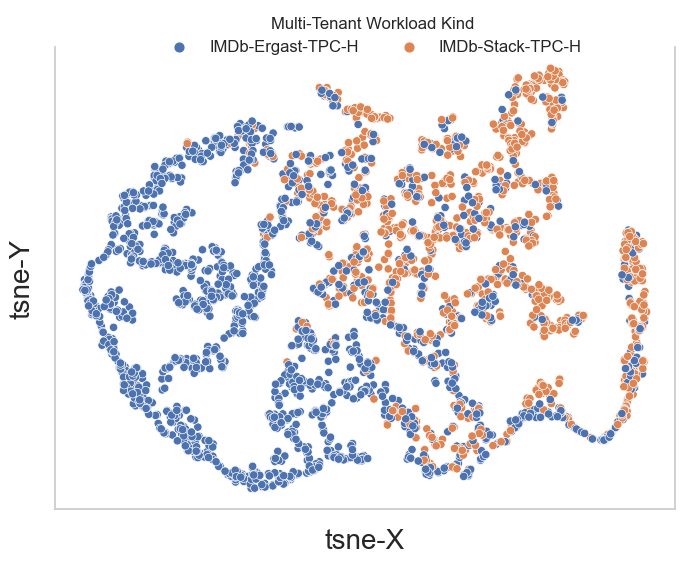

In [722]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

embeds = np.array(embeds)

tsne_em = TSNE(n_components=2, n_iter=500).fit_transform(embeds)

# Assuming tsne_em and df are already defined
curdf = pd.DataFrame({'x': tsne_em[:,0], 'y': tsne_em[:,1], 
                      'tags': df["workload_kind"].values
                     })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

sns.scatterplot(data=curdf, x="x", y="y", hue="tags", ax=ax, 
                alpha=1.0)

# Create the legend
h, l = ax.get_legend_handles_labels()
legend = ax.legend(h, l, loc='upper left', bbox_to_anchor=(0.15, 1.10), 
                   ncol=5, frameon=False, fontsize=12)
legend.set_title("Multi-Tenant Workload Kind", prop={'size': '12'})

# Increase the size of the scatter dots in the legend
for handle in legend.legendHandles:
    handle.set_sizes([40])  # Adjust this value as needed for size

# Add x and y labels
ax.set_xlabel('tsne-X', fontsize=20)
ax.set_ylabel('tsne-Y', fontsize=20)

# Remove x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove gridlines
ax.grid(False)

# Show plot boundaries
sns.despine(fig=fig, ax=ax, top=True, right=False, left=False, bottom=False)

outname = FN_TMP.format(HUE="WorkloadKind")
print(outname)
plt.savefig(outname, bbox_inches="tight")


TSNE-Embed-IMDb-MultiTenant-InstanceKind.png


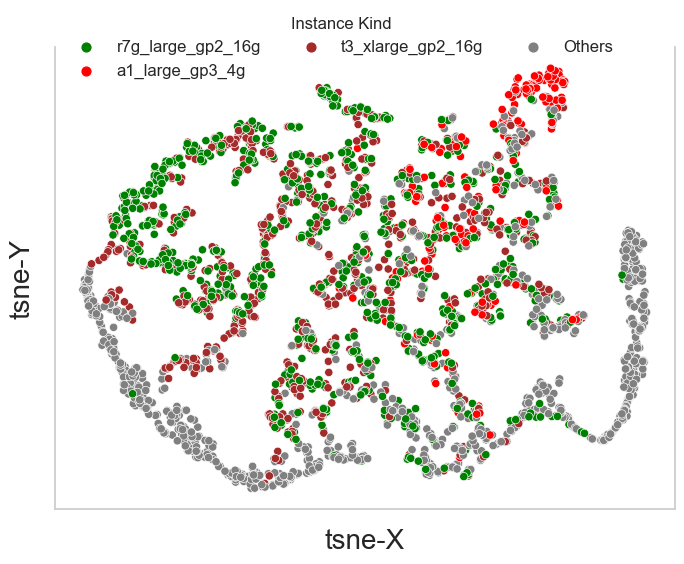

In [720]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Assuming tsne_em and df are already defined
curdf = pd.DataFrame({'x': tsne_em[:,0], 'y': tsne_em[:,1], 
                      'tags': df["instance_label"].values
                     })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

sns.scatterplot(data=curdf, x="x", y="y", hue="tags", ax=ax, 
                alpha=1.0,
                hue_order=INSTANCE_ORDER,
                palette=INSTANCE_HUES,
               )

# Create the legend
h, l = ax.get_legend_handles_labels()
legend = ax.legend(h, l, loc='upper left', 
                   bbox_to_anchor=(0.0, 1.10), 
                   ncol=3, frameon=False, fontsize=12)
legend.set_title("Instance Kind", prop={'size': '12'})


# Increase the size of the scatter dots in the legend
for handle in legend.legendHandles:
    handle.set_sizes([40])  # Adjust this value as needed for size

# Add x and y labels
ax.set_xlabel('tsne-X', fontsize=20)
ax.set_ylabel('tsne-Y', fontsize=20)

# Remove x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove gridlines
ax.grid(False)

# Show plot boundaries
sns.despine(fig=fig, ax=ax, top=True, right=False, left=False, bottom=False)

outname = FN_TMP.format(HUE="InstanceKind")
print(outname)
plt.savefig(outname, bbox_inches="tight")


In [707]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming tsne_em and df are already defined
# curdf = pd.DataFrame({'x': tsne_em[:, 0], 'y': tsne_em[:, 1], 
#                       #'hue': df["latency_z_score"].values
#                       'hue': avgs[:,2]
#                      })

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

# # Create the scatter plot using a colormap
# scatter = sns.scatterplot(data=curdf, x="x", y="y", hue="hue", 
#                           ax=ax, alpha=0.5, size=6, palette="viridis")

# ax.legend().remove()
# # Add a colorbar
# sm = plt.cm.ScalarMappable(cmap="viridis", 
#                            norm=plt.Normalize(curdf['hue'].min(), curdf['hue'].max()
#                                              ))
# sm.set_array([])
# fig.colorbar(sm, ax=ax, orientation='vertical')

# # Plot adjustments
# outname = fn.replace(".pkl", "_%fio.pdf")
# print(outname)
# # plt.savefig(outname, bbox_inches="tight")


TSNE-Embed-IMDb-MultiTenant-fio.png


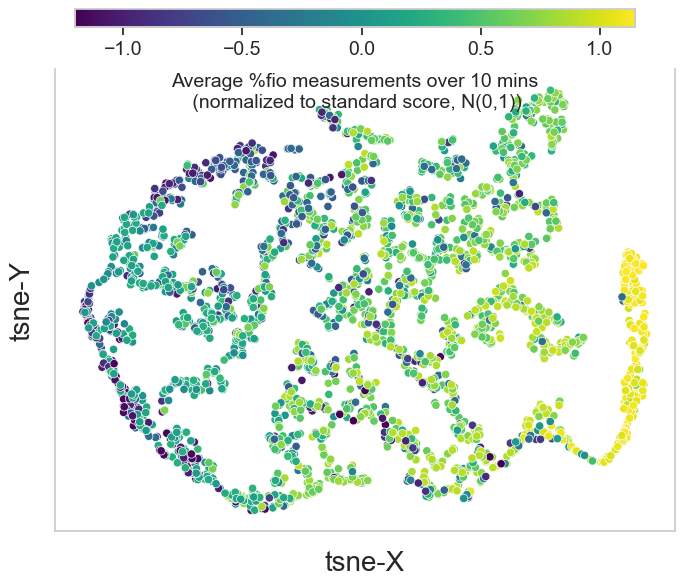

In [727]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Assuming tsne_em and df are already defined
curdf = pd.DataFrame({'x': tsne_em[:,0], 'y': tsne_em[:,1], 
                       'hue': avgs[:,2],
                     })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

sns.scatterplot(data=curdf, x="x", y="y", hue="hue", ax=ax, 
                alpha=1.0, palette="viridis")

# Remove the default legend
ax.legend().remove()

# Normalize the colorbar
norm = plt.Normalize(curdf['hue'].min(), curdf['hue'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Adjust the position of the colorbar
cbar_ax = fig.add_axes([0.15, 0.95, 0.7, 0.03]) # Adjust the second value to lower the colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14) # Adjust label size for colorbar
cbar.set_label("Average %fio measurements over 10 mins\n (normalized to standard score, N(0,1))", 
               fontsize=14, labelpad=10)

# Add x and y labels
ax.set_xlabel('tsne-X', fontsize=20)
ax.set_ylabel('tsne-Y', fontsize=20)

# Remove x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove gridlines
ax.grid(False)

# Show plot boundaries
sns.despine(fig=fig, ax=ax, top=True, right=False, left=False, bottom=False)

outname = FN_TMP.format(HUE="fio")
print(outname)
plt.savefig(outname, bbox_inches="tight")


In [709]:
curdf['hue'].min()

-1.2038133

# Avg tsne embedding

In [711]:
# import pickle
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.manifold import TSNE

# embeds = np.array(embeds)

# tsne_em_avg = TSNE(n_components=2, n_iter=500).fit_transform(avgs)

# curdf = pd.DataFrame({'x': tsne_em_avg[:,0], 'y': tsne_em_avg[:,1], 
#                       'hue': df["workload_kind"].values
#                      })

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

# sns.scatterplot(data=curdf, x="x", y="y", 
#                 hue="hue", ax=ax, alpha=1.0,
#                )

# # Set the legend
# h, l = ax.get_legend_handles_labels()
# legend = ax.legend(h, l, loc='upper left', bbox_to_anchor=(0.0, 1.10), 
#                    ncol=1, frameon=False, fontsize='large')
# legend.set_title("Workload Kind", prop={'size': 'x-large'})

# # Set the title
# ax.set_title("TSNE embedding of average of system log vector,\n colored by kind of multi-tenant workload", fontsize=16, pad=20)

# # Remove x and y labels
# ax.set_xlabel('')
# ax.set_ylabel('')

# # Remove x and y tick marks
# ax.set_xticks([])
# ax.set_yticks([])

# # Remove grids and boundaries
# ax.grid(False)
# sns.despine(fig=fig, ax=ax, top=True, right=True, left=True, bottom=True)

# outname = FN_TMP.format(HUE="WorkloadKind")
# print(outname)
# plt.savefig(outname, bbox_inches="tight")


TSNE-Embed-IMDb-MultiTenant-Avg-InstanceKind.png


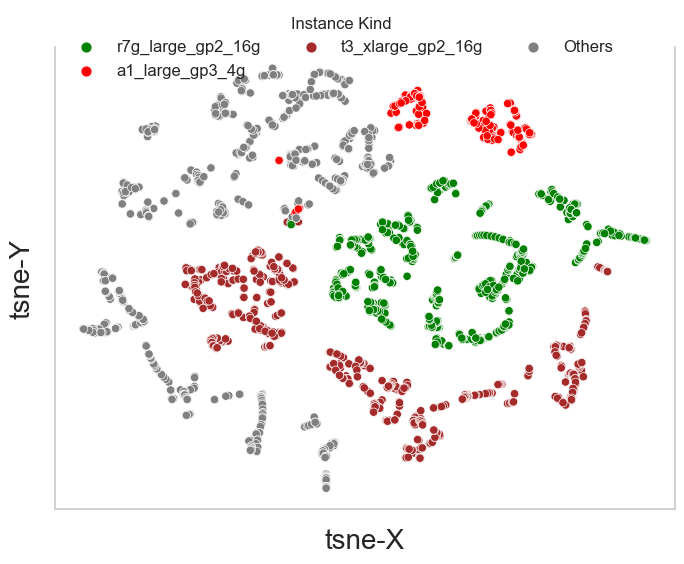

In [717]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

embeds = np.array(embeds)

tsne_em_avg = TSNE(n_components=2, n_iter=500).fit_transform(avgs)


# Assuming tsne_em and df are already defined
curdf = pd.DataFrame({'x': tsne_em_avg[:,0], 'y': tsne_em_avg[:,1], 
                      'tags': df["instance_label"].values
                     })

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

sns.scatterplot(data=curdf, x="x", y="y", hue="tags", 
                ax=ax, alpha=1.0,
                palette=INSTANCE_HUES,
                hue_order=INSTANCE_ORDER,
               )

# Create the legend
h, l = ax.get_legend_handles_labels()
legend = ax.legend(h, l, loc='upper left', 
                   bbox_to_anchor=(0.0, 1.10), 
                   ncol=3, frameon=False, fontsize=12)
legend.set_title("Instance Kind", prop={'size': '12'})


# Increase the size of the scatter dots in the legend
for handle in legend.legendHandles:
    handle.set_sizes([40])  # Adjust this value as needed for size

# Add x and y labels
ax.set_xlabel('tsne-X', fontsize=20)
ax.set_ylabel('tsne-Y', fontsize=20)

# Remove x and y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove gridlines
ax.grid(False)

# Show plot boundaries
sns.despine(fig=fig, ax=ax, top=True, right=False, left=False, bottom=False)




outname = FN_TMP.format(HUE="Avg-InstanceKind")
print(outname)
plt.savefig(outname, bbox_inches="tight")
